In [11]:
from IPython.display import display, Image
from keras.utils import plot_model
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import *
import time

from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from tensorflow.keras.callbacks import EarlyStopping

# Start counting notebook running time
time_start = time.time()


df = pd.read_csv('wind_dataset.csv', sep=',')


column = ["IND.1", "T.MAX", "IND.2", "T.MIN", "T.MIN.G"]
for i in column:
    print(i)
    print(df[i].mode())
FilterInd1 = 0.0
FilterTmax = 10.0
FilterInd = 0.0
FilterTMIN = 9.0
FilterTMIN_g = 5.0
df["IND.1"].fillna(FilterInd1, inplace=True)
df["T.MAX"].fillna(FilterTmax, inplace=True)
df["IND.2"].fillna(FilterInd, inplace=True)
df["T.MIN"].fillna(FilterTMIN, inplace=True)
df["T.MIN.G"].fillna(FilterTMIN_g, inplace=True)

df = df.fillna(0)
data_L = df.drop(['DATE'], axis=1)
6469*0.6
train_df, test_df = data_L[1:3881], data_L[3881:]

train = train_df.copy()
test = test_df.copy()
scalers = {}

n_past = 10
n_future = 5

IND.1
0    0.0
Name: IND.1, dtype: float64
T.MAX
0    10.0
Name: T.MAX, dtype: float64
IND.2
0    0.0
Name: IND.2, dtype: float64
T.MIN
0    9.0
Name: T.MIN, dtype: float64
T.MIN.G
0    5.0
Name: T.MIN.G, dtype: float64


### EDA & Feature engineering

In [12]:
# Converting Date to date time format
df['DATE'] = pd.to_datetime(df['DATE'])

# Feature engineering on Date
df['year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.day
df.head()


DATE   WIND  IND  RAIN  IND.1  T.MAX  IND.2  T.MIN  T.MIN.G  year  \
0 1961-01-01  13.67    0   0.2    0.0    9.5    0.0    3.7     -1.0  1961   
1 1961-01-02  11.50    0   5.1    0.0    7.2    0.0    4.2      1.1  1961   
2 1961-01-03  11.25    0   0.4    0.0    5.5    0.0    0.5     -0.5  1961   
3 1961-01-04   8.63    0   0.2    0.0    5.6    0.0    0.4     -3.2  1961   
4 1961-01-05  11.92    0  10.4    0.0    7.2    1.0   -1.5     -7.5  1961   

   Month  day  
0      1    1  
1      1    2  
2      1    3  
3      1    4  
4      1    5

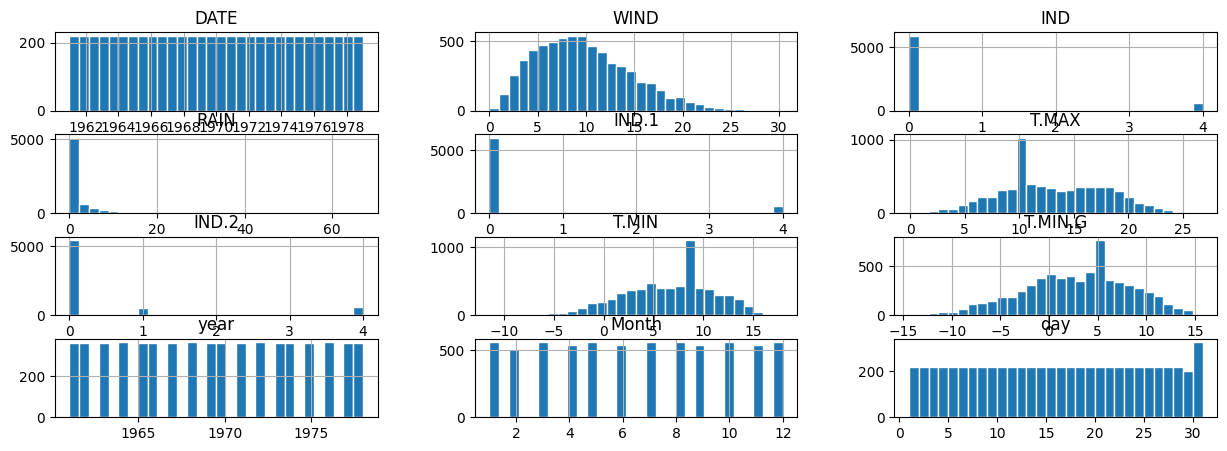

In [13]:
# EDA
df.hist(bins=30, ec="white")
plt.grid(False)
plt.show()


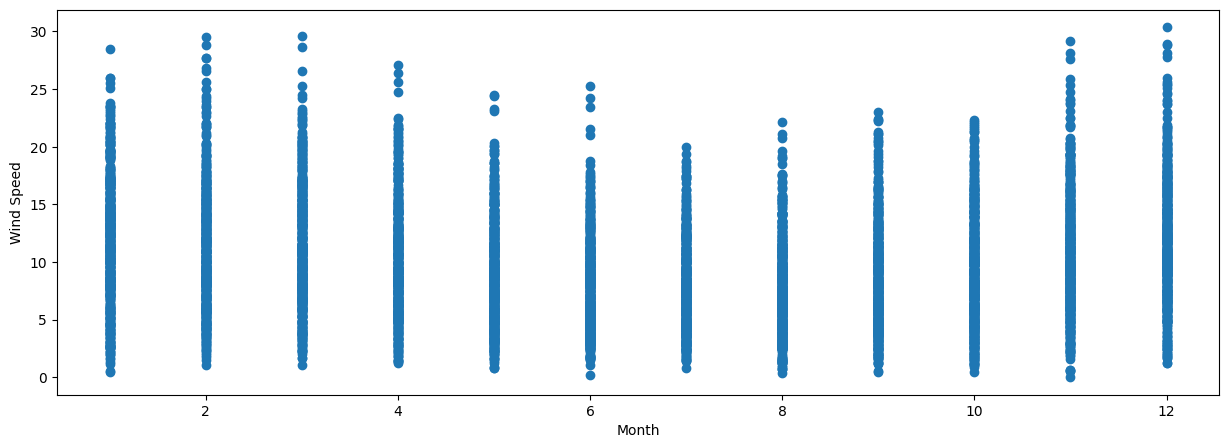

In [14]:
# Is month has a relation with wind?
month = df["Month"]
wind = df['WIND']
plt.xlabel('Month')
plt.ylabel('Wind Speed')
plt.scatter(month, wind)
plt.show()

form this Scatter we found that: in (2,3,11,12) months the wind speed is high. , then we can estimate that it has a relation! , but we need some analysis 

<Axes: >

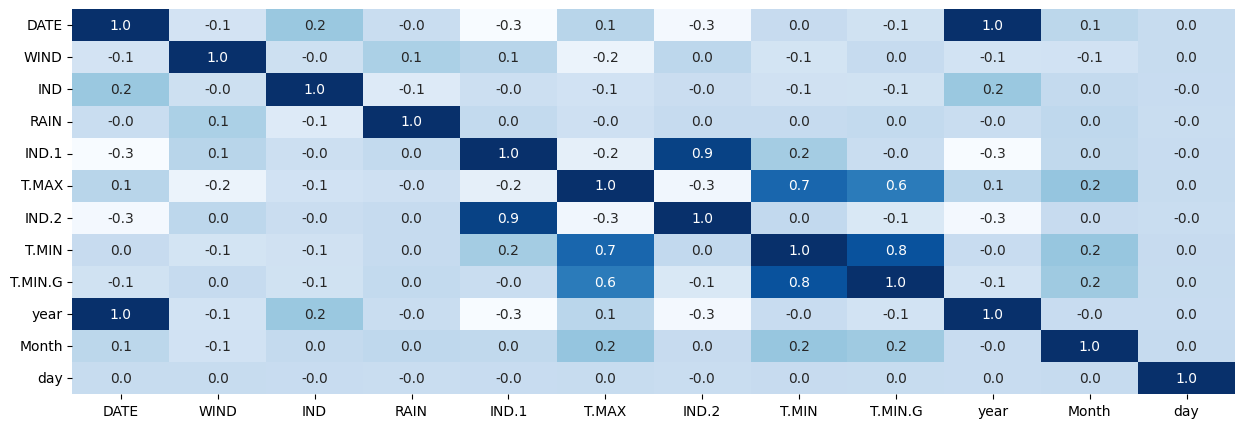

In [15]:
# Correlation
sns.heatmap(df.corr(), annot=True, cbar=False, cmap='Blues', fmt='.1f')

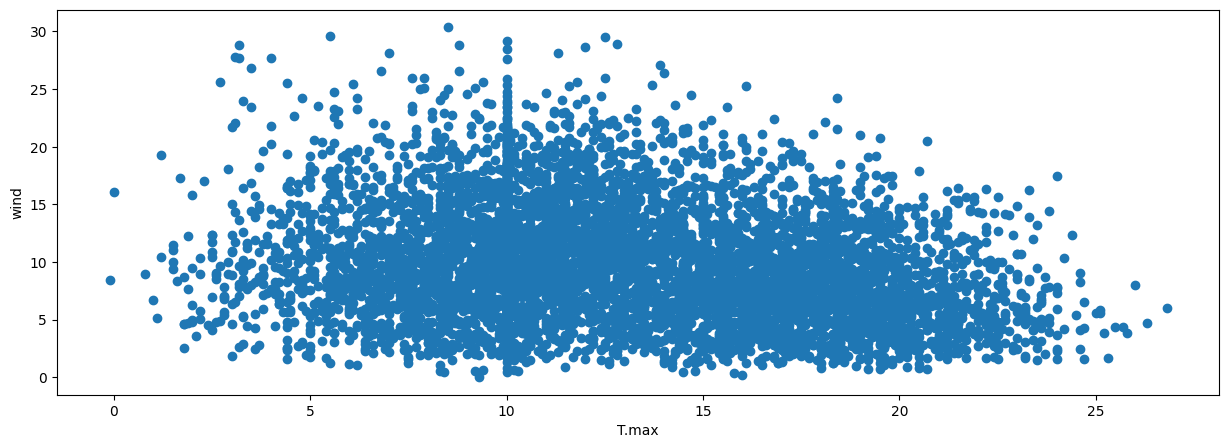

In [16]:
# is temperature has a replation with wind speed?

plt.xlabel("T.max")
plt.ylabel("wind")
plt.scatter(df['T.MAX'], wind)
plt.show()

There is no relation we could find here 

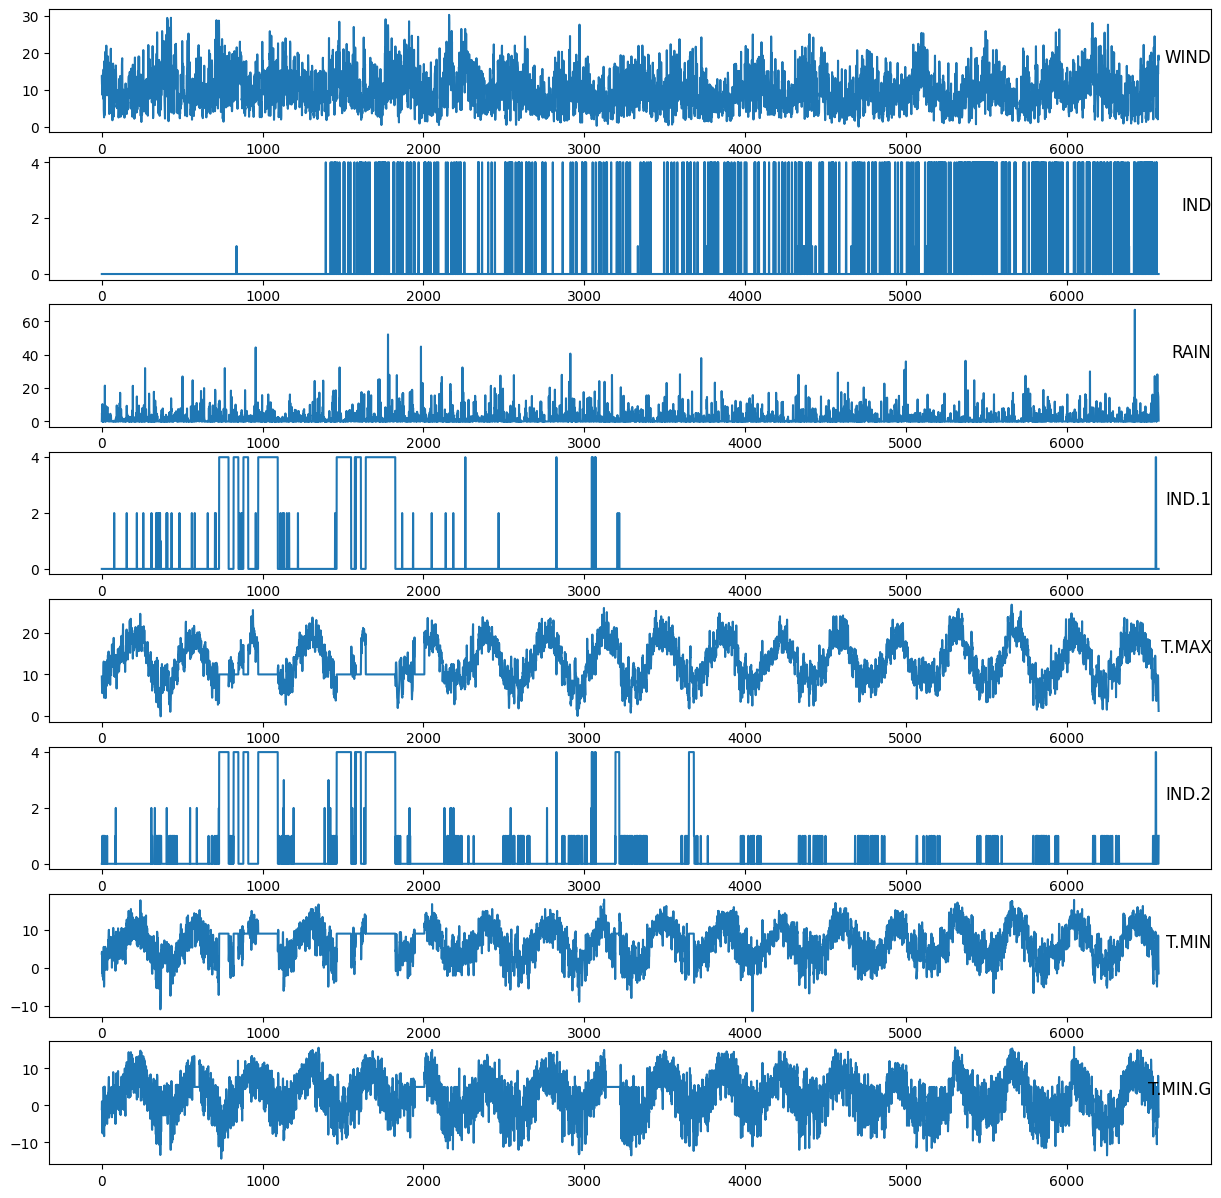

In [17]:
# We will look for the relation between all data and wind

# load dataset
dPlot = df.drop(['DATE'], axis=1)
values = dPlot.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(15, 15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dPlot.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

WIND
False    6538
True       36
Name: count, dtype: int64

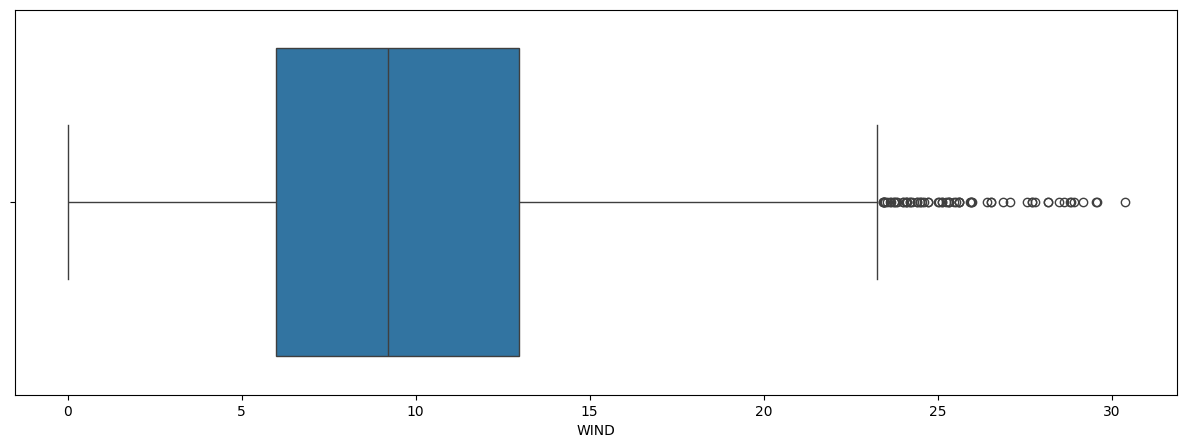

In [18]:
# To check any outlier... if there is any outlier, then drop it

sns.boxplot(x=df['WIND'])
filter1 = (df['WIND'] > 25)
filter1.value_counts()

There are 36 outlier values

In [19]:
# drop all the outliers
for i in np.where(df["WIND"] >= 23):
    df.drop(i, inplace=True)

most of outlier is fixed ! but still rain has outliers

<Axes: xlabel='IND', ylabel='WIND'>

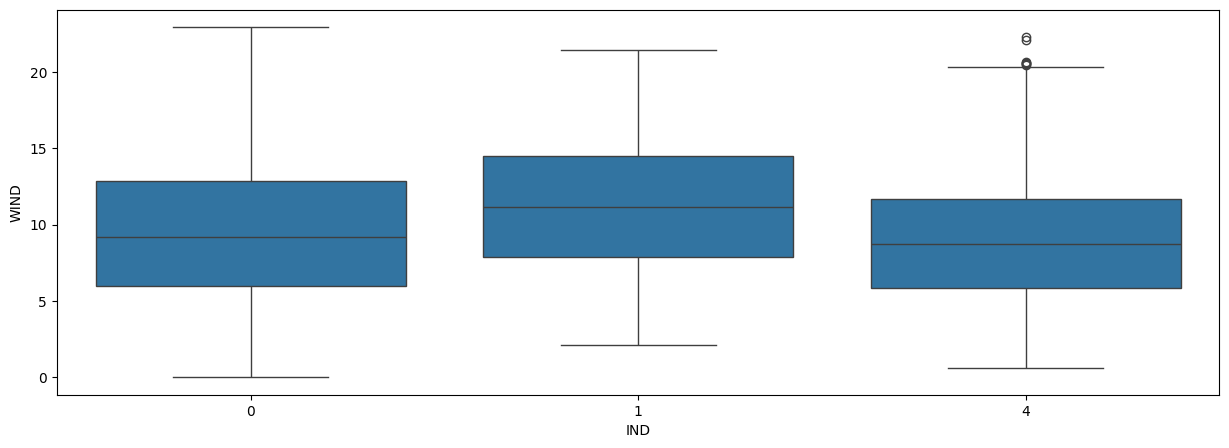

In [20]:
# Most of outlier is fixed! but still rain has outliers
for k in np.where(df["RAIN"] >= 25):
    df.drop(k, inplace=True)
sns.boxplot(x=df['IND'], y=df["WIND"])


That is the big evidence that most of outliers is fixed

There is more outlier in data ....?


<Axes: xlabel='Month', ylabel='WIND'>

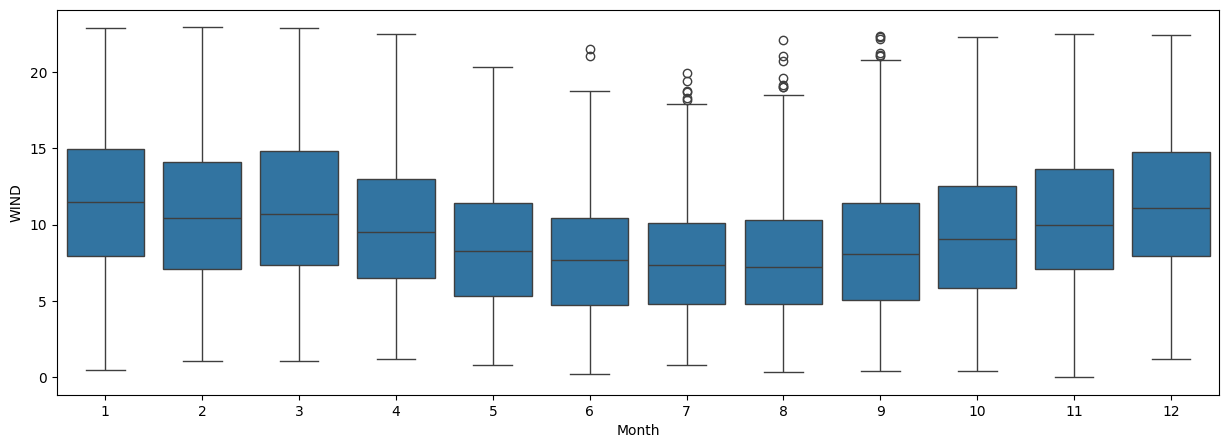

In [21]:
# To check is there any outlier?

sns.boxplot(x=df['Month'], y=df["WIND"])

(array([ 196.,  789., 1078., 1199., 1100.,  813.,  594.,  387.,  211.,
         102.]),
 array([ 0.   ,  2.295,  4.59 ,  6.885,  9.18 , 11.475, 13.77 , 16.065,
        18.36 , 20.655, 22.95 ]),
 <BarContainer object of 10 artists>)

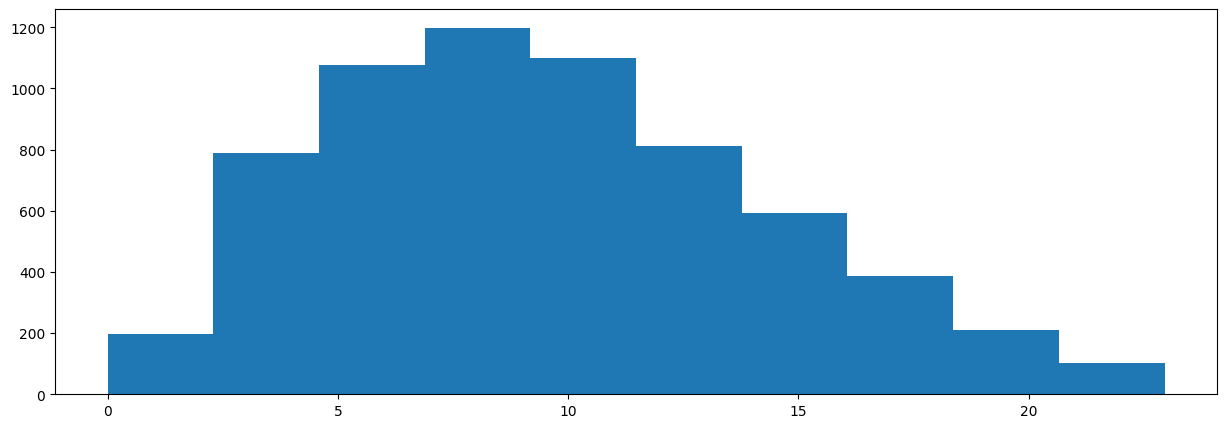

In [22]:
# what is the best month for maximum wind energy?
plt.hist(df["WIND"])  # to get the most repeated value



In [23]:
filter2 = df[(df['WIND'] >= 10)]
pd.DataFrame(filter2['Month'].value_counts())



count
Month       
1        332
12       323
3        300
11       263
2        261
4        247
10       233
9        193
5        192
6        156
7        150
8        146

The best Month to Turn ON Turbine is between (11 , 3) , beacuse we found that the maximum wind speed in these months and if we don't remove the outlier the output is same

In [24]:
# the best month to turn on Turbine considering the rain
filter3 = df[(df['WIND'] >= 10) & (df["RAIN"] <= 10)]
pd.DataFrame(filter3['Month'].value_counts())

count
Month       
1        311
12       301
3        285
11       251
2        250
4        234
10       221
5        185
9        176
6        154
7        146
8        139


We found that the best month is between(11,4)

but the best of the best is (12,1)


### Deep Learning model

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 10, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ [(None, 100),     │     43,600 │ input_layer_6[0]… │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 5, 100)    │          0 │ lstm_12[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 5, 100)    │     80,400 │ repeat_vector_6[… │
│                     │                   │            │ lstm_12[0][1],    │
│                     │                   │            │ lstm_12[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 5, 8)      │        808 │ lstm_13[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 124,808 (487.53 KB)

 Trainable params: 124,808 (487.53 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 10, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ [(None, 10, 100), │     43,600 │ input_layer_7[0]… │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ [(None, 100),     │     80,400 │ lstm_14[0][0]     │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_7     │ (None, 5, 100)    │          0 │ lstm_15[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 5, 100)    │     80,400 │ repeat_vector_7[… │
│                     │                   │            │ lstm_14[0][1],    │
│                     │                   │            │ lstm_14[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 5, 100)    │     80,400 │ lstm_16[0][0],    │
│                     │                   │            │ lstm_15[0][1],    │
│                     │                   │            │ lstm_15[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 5, 8)      │        808 │ lstm_17[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 285,608 (1.09 MB)

 Trainable params: 285,608 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 10, 64)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_8 (RepeatVector)  │ (None, 5, 640)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 5, 64)          │       122,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 5, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 5, 8)           │         1,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 5, 8)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,792 (589.03 KB)

 Trainable params: 150,792 (589.03 KB)

 Non-trainable params: 0 (0.00 B)

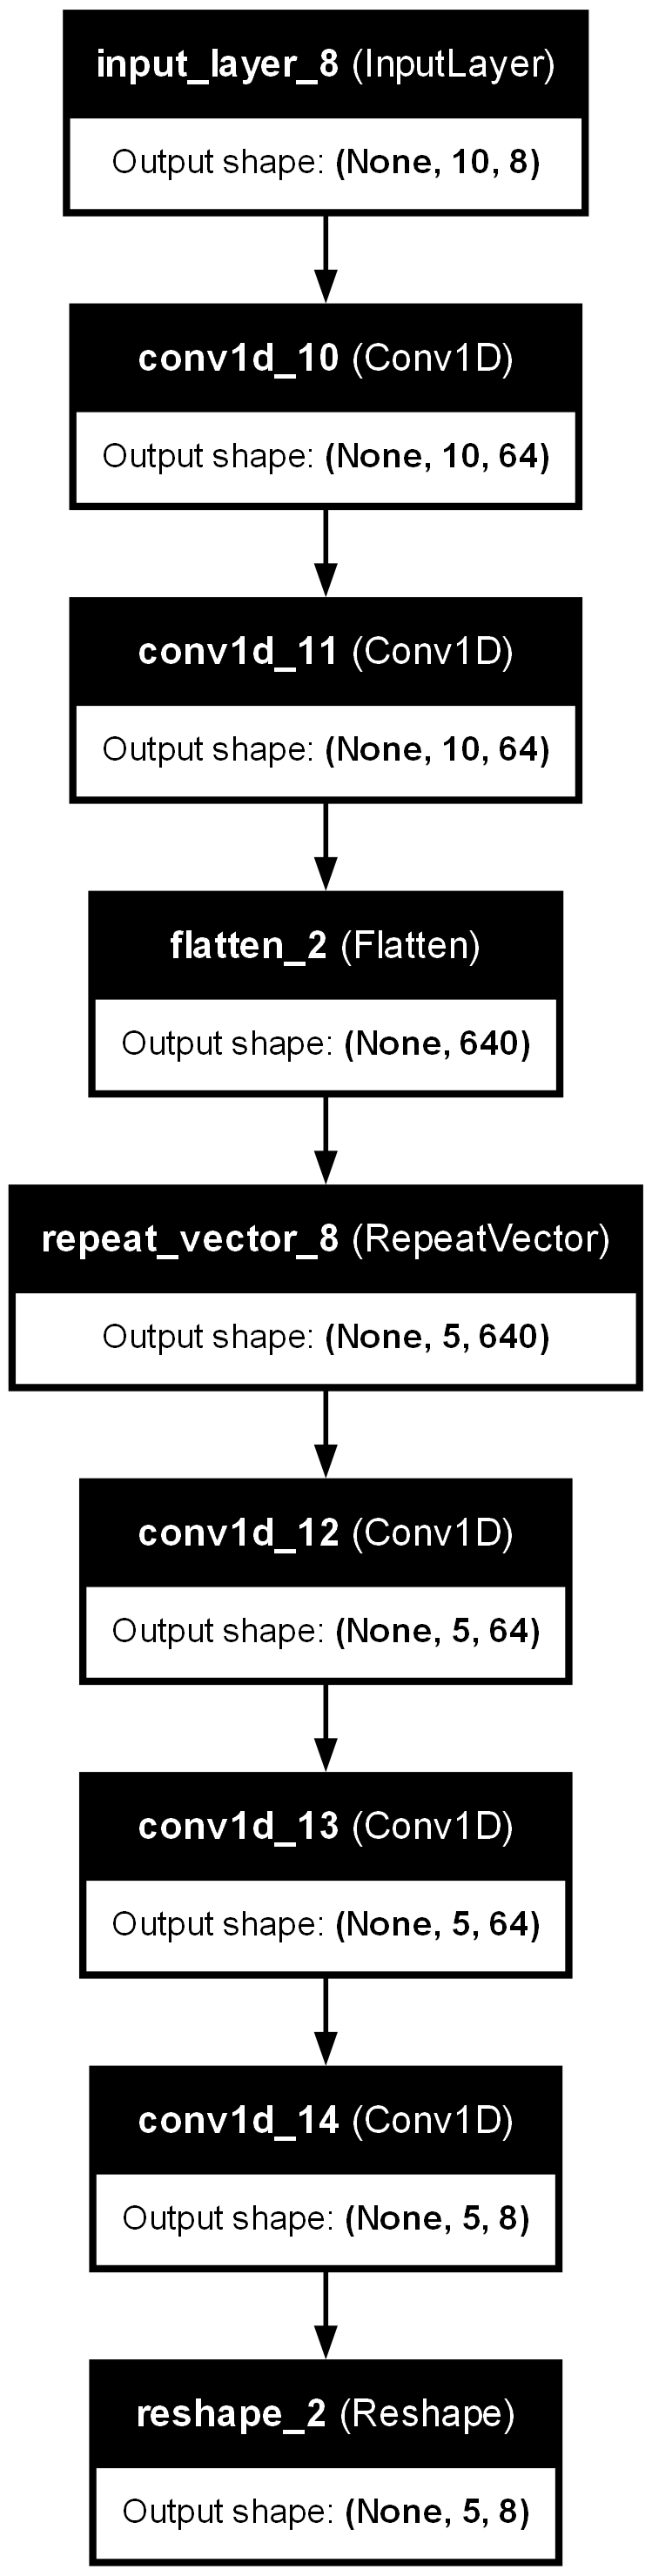

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 10, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ [(None, 100),     │     43,600 │ input_layer_6[0]… │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 5, 100)    │          0 │ lstm_12[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 5, 100)    │     80,400 │ repeat_vector_6[… │
│                     │                   │            │ lstm_12[0][1],    │
│                     │                   │            │ lstm_12[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 5, 8)      │        808 │ lstm_13[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 374,426 (1.43 MB)

 Trainable params: 124,808 (487.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 249,618 (975.07 KB)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 10, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ [(None, 10, 100), │     43,600 │ input_layer_7[0]… │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ [(None, 100),     │     80,400 │ lstm_14[0][0]     │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_7     │ (None, 5, 100)    │          0 │ lstm_15[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 5, 100)    │     80,400 │ repeat_vector_7[… │
│                     │                   │            │ lstm_14[0][1],    │
│                     │                   │            │ lstm_14[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 5, 100)    │     80,400 │ lstm_16[0][0],    │
│                     │                   │            │ lstm_15[0][1],    │
│                     │                   │            │ lstm_15[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 5, 8)      │        808 │ lstm_17[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 856,826 (3.27 MB)

 Trainable params: 285,608 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 571,218 (2.18 MB)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 10, 64)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_8 (RepeatVector)  │ (None, 5, 640)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 5, 64)          │       122,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 5, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 5, 8)           │         1,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 5, 8)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,378 (1.73 MB)

 Trainable params: 150,792 (589.03 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 301,586 (1.15 MB)

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


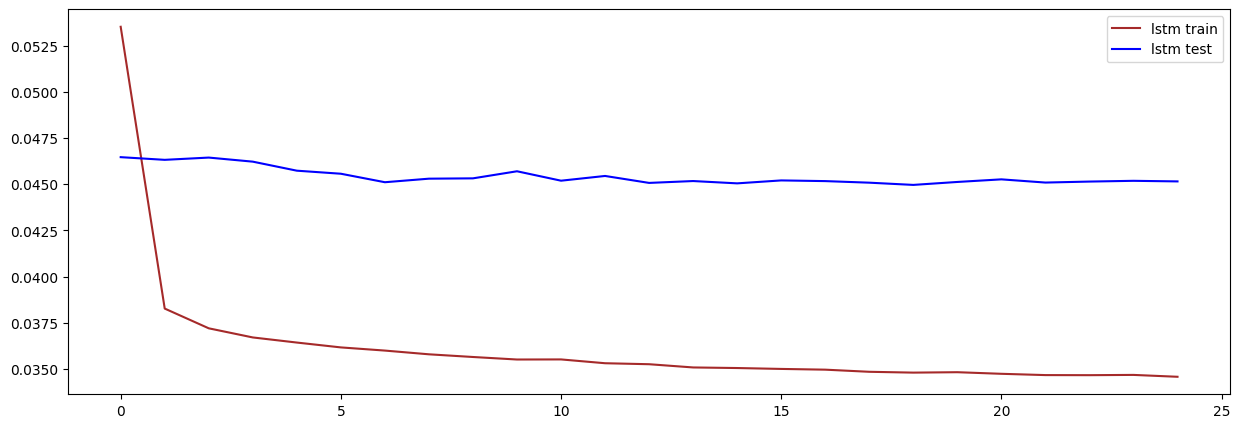

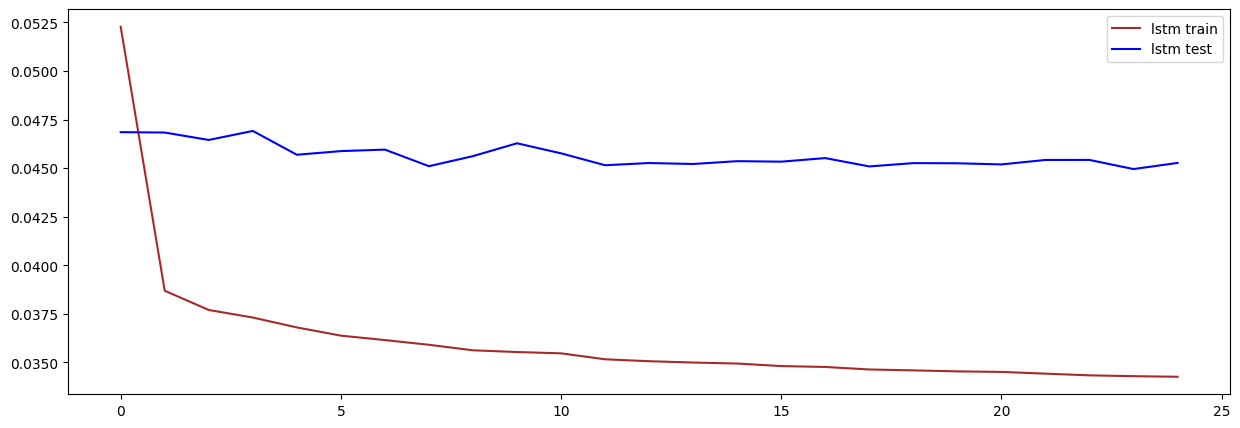

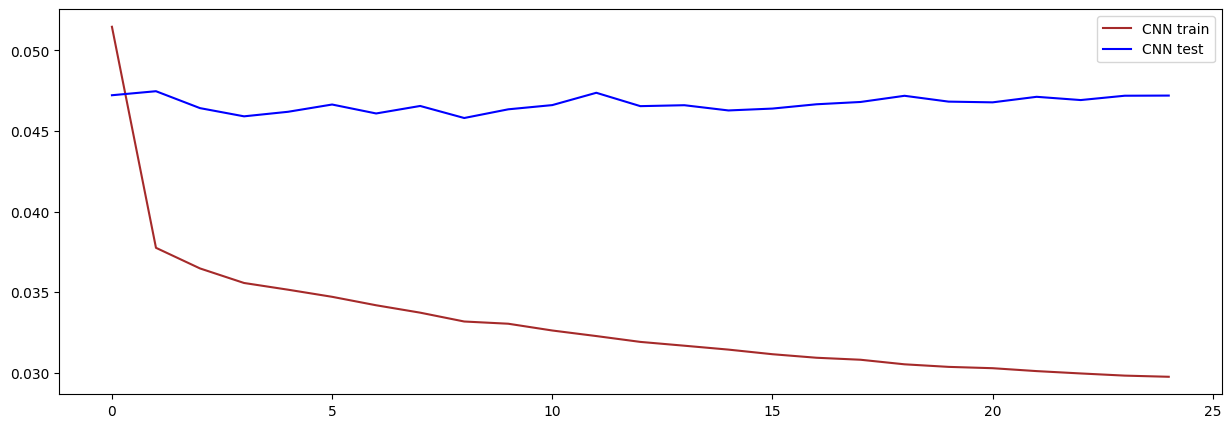

WIND
Day  1 :
MAE-E1D1 :  3.099302278677444, MAE-E2D2 :  3.110098746674592
MAE-CNN :  3.1107562249158023
MSE-E1D1 :  15.254547516732874, MSE-E2D2 :  15.466379475144723
MSE-CNN :  15.407366973043736
R2-E1D1 :  0.3353102524627657, R2-E2D2 :  0.32608005203875157
R2-CNN :  0.32865141674688336
RMSE-E1D1 :  3.9057070444073085, RMSE-E2D2 :  3.932731808189407
RMSE-CNN :  3.9252219011214815
Day  2 :
MAE-E1D1 :  3.485813258983787, MAE-E2D2 :  3.474529531200504
MAE-CNN :  3.586198314592526
MSE-E1D1 :  19.18066524716514, MSE-E2D2 :  19.279450995764915
MSE-CNN :  20.587564566701666
R2-E1D1 :  0.16452384189420366, R2-E2D2 :  0.1602209078378395
R2-CNN :  0.10324177356230557
RMSE-E1D1 :  4.379573637600485, RMSE-E2D2 :  4.390837163430787
RMSE-CNN :  4.537352153701723
Day  3 :
MAE-E1D1 :  3.5892166927475766, MAE-E2D2 :  3.582669259349372
MAE-CNN :  3.7329383902391333
MSE-E1D1 :  20.10937025291312, MSE-E2D2 :  20.20803361177708
MSE-CNN :  22.143284213438005
R2-E1D1 :  0.12534929448272636, R2-E2D2 :  0.12

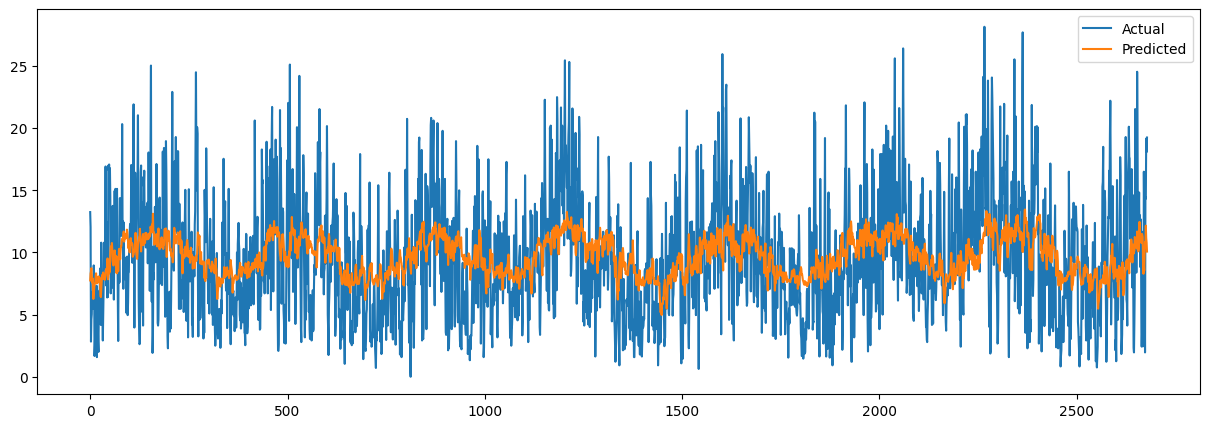

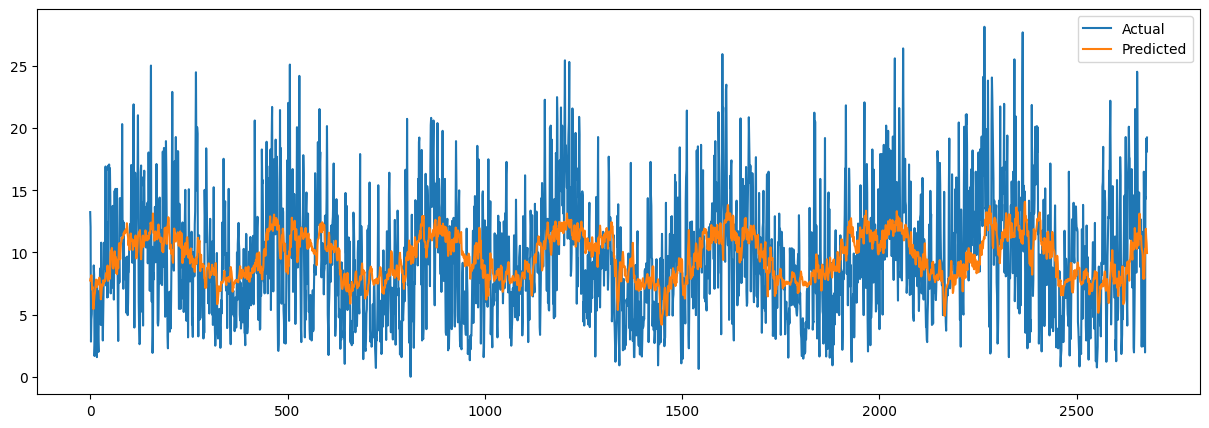

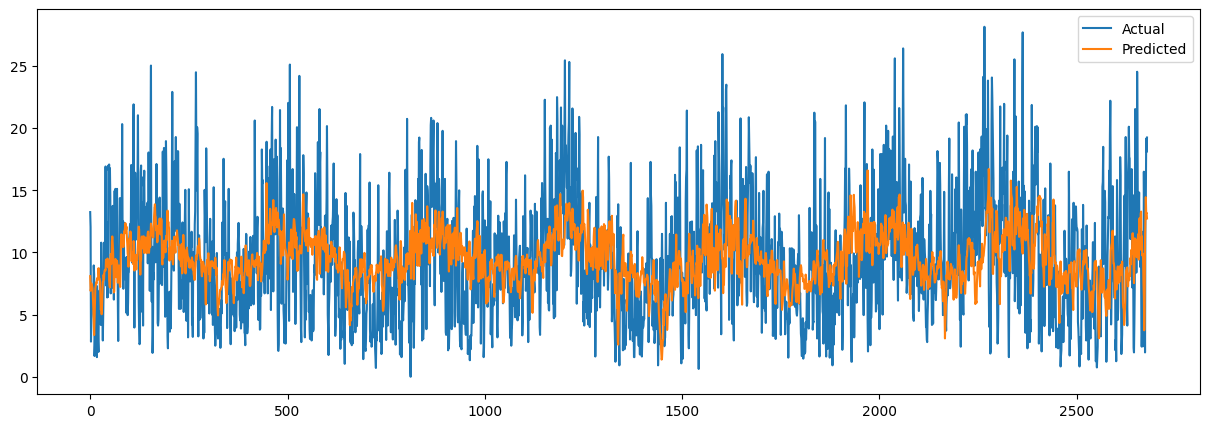

IND
Day  1 :
MAE-E1D1 :  0.7150841458335925, MAE-E2D2 :  0.7136637727108052
MAE-CNN :  0.7480520810062826
MSE-E1D1 :  2.1328077123653615, MSE-E2D2 :  2.161238296589711
MSE-CNN :  2.140849798469923
R2-E1D1 :  -0.05122468034981442, R2-E2D2 :  -0.06523763221609125
R2-CNN :  -0.055188487938093056
RMSE-E1D1 :  1.4604135415577881, RMSE-E2D2 :  1.470115062364069
RMSE-CNN :  1.463164310140841
Day  2 :
MAE-E1D1 :  0.7068728901815753, MAE-E2D2 :  0.7077345757308225
MAE-CNN :  0.753317071413451
MSE-E1D1 :  2.226312011454235, MSE-E2D2 :  2.236624404932335
MSE-CNN :  2.196728762021179
R2-E1D1 :  -0.09731136052785194, R2-E2D2 :  -0.10239416404305257
R2-CNN :  -0.08273027956651013
RMSE-E1D1 :  1.4920831114432718, RMSE-E2D2 :  1.4955348223737002
RMSE-CNN :  1.482136553095287
Day  3 :
MAE-E1D1 :  0.6927502375122503, MAE-E2D2 :  0.6953042325532094
MAE-CNN :  0.7639621881550486
MSE-E1D1 :  2.270853378960205, MSE-E2D2 :  2.270563180657097
MSE-CNN :  2.217557404405429
R2-E1D1 :  -0.11926504371614022, R2-E2

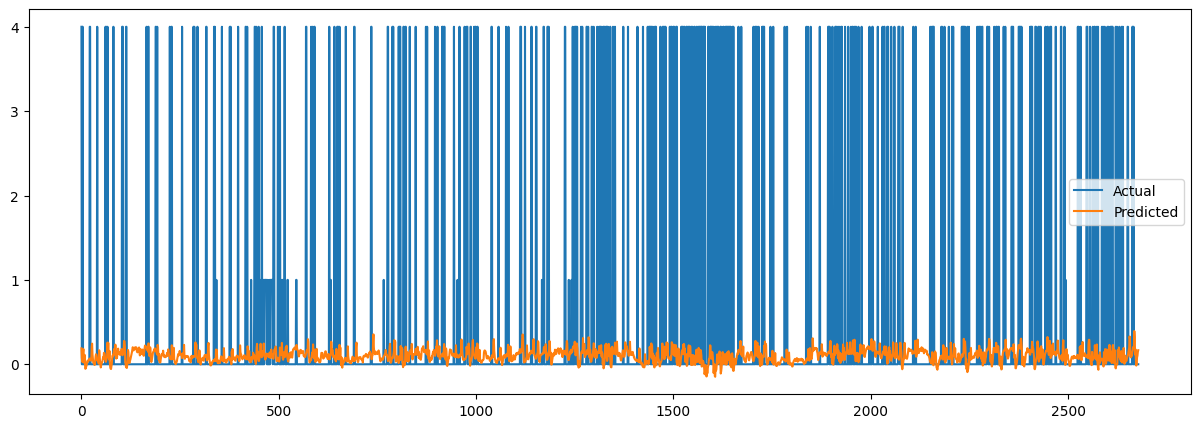

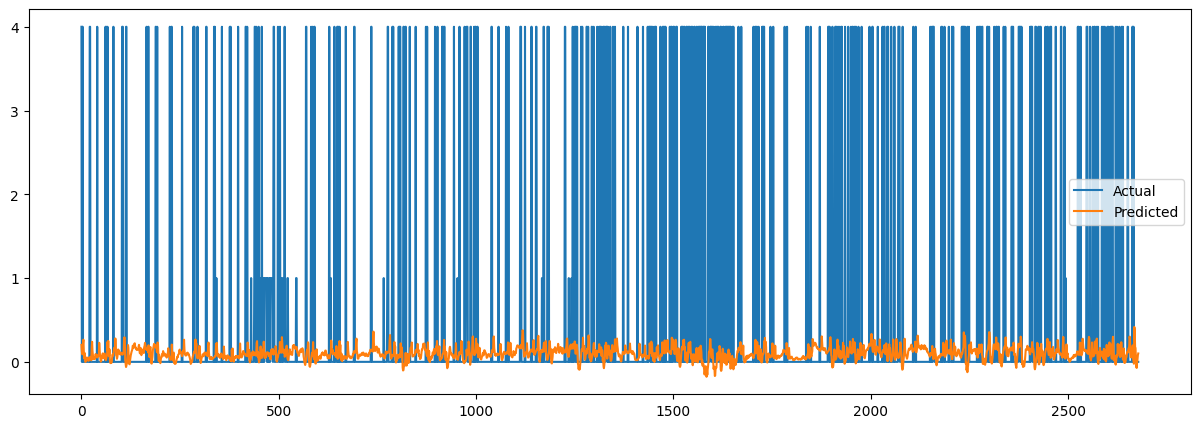

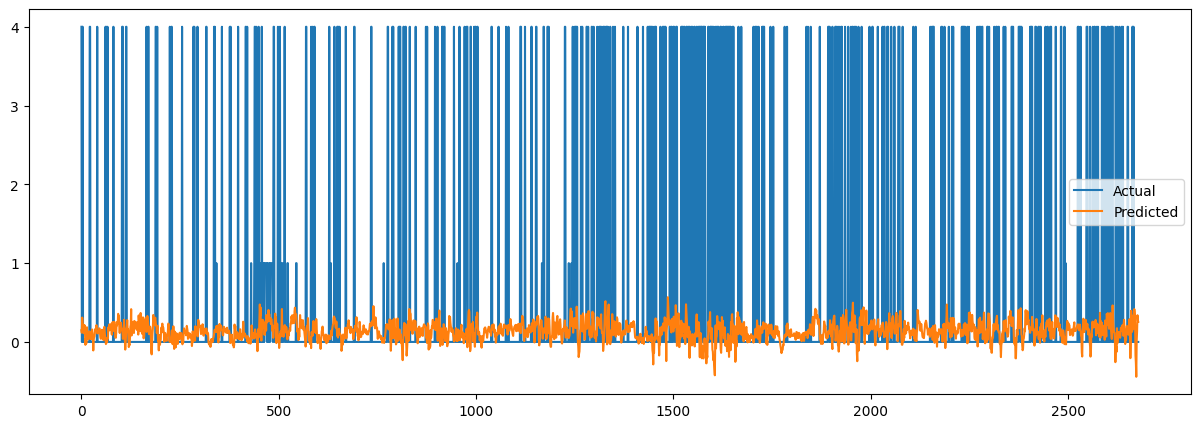

RAIN
Day  1 :
MAE-E1D1 :  2.413234106305543, MAE-E2D2 :  2.2343433903850416
MAE-CNN :  2.4176482096074903
MSE-E1D1 :  14.731118524399458, MSE-E2D2 :  14.585207725407338
MSE-CNN :  15.474681487665565
R2-E1D1 :  0.015738078399661015, R2-E2D2 :  0.025487130595551855
R2-CNN :  -0.03394319392483669
RMSE-E1D1 :  3.838113928011968, RMSE-E2D2 :  3.8190584867748933
RMSE-CNN :  3.933787168577574
Day  2 :
MAE-E1D1 :  2.4459337853682315, MAE-E2D2 :  2.3823630083136793
MAE-CNN :  2.5262935155808397
MSE-E1D1 :  14.965104929746746, MSE-E2D2 :  14.900054394569016
MSE-CNN :  15.668576703571624
R2-E1D1 :  0.0039051471578815944, R2-E2D2 :  0.008234986712588821
R2-CNN :  -0.04291875526820954
RMSE-E1D1 :  3.868475788957034, RMSE-E2D2 :  3.8600588589513785
RMSE-CNN :  3.9583553028463254
Day  3 :
MAE-E1D1 :  2.4375328040114086, MAE-E2D2 :  2.3635490414009652
MAE-CNN :  2.694788145860042
MSE-E1D1 :  15.043472163437462, MSE-E2D2 :  14.982874042339375
MSE-CNN :  16.18648570761999
R2-E1D1 :  0.002763547769168761

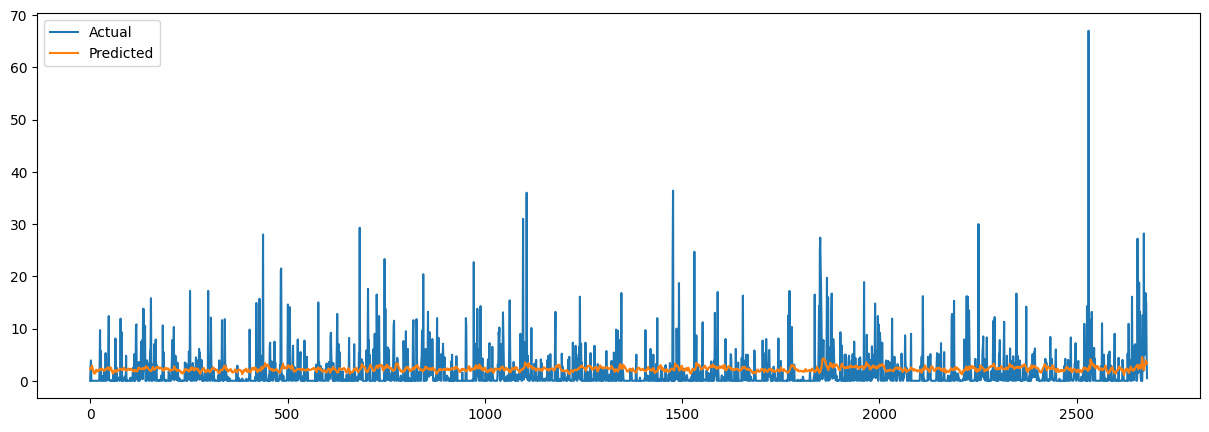

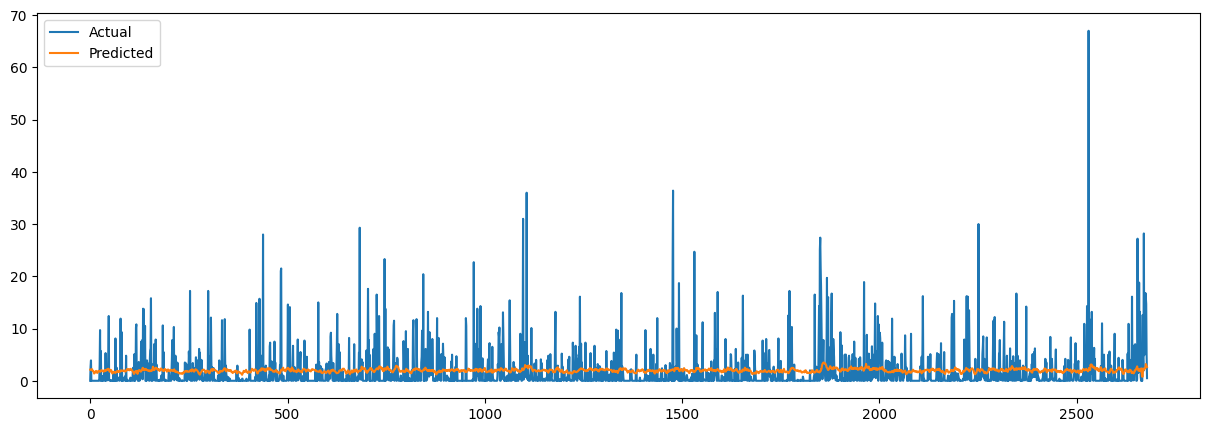

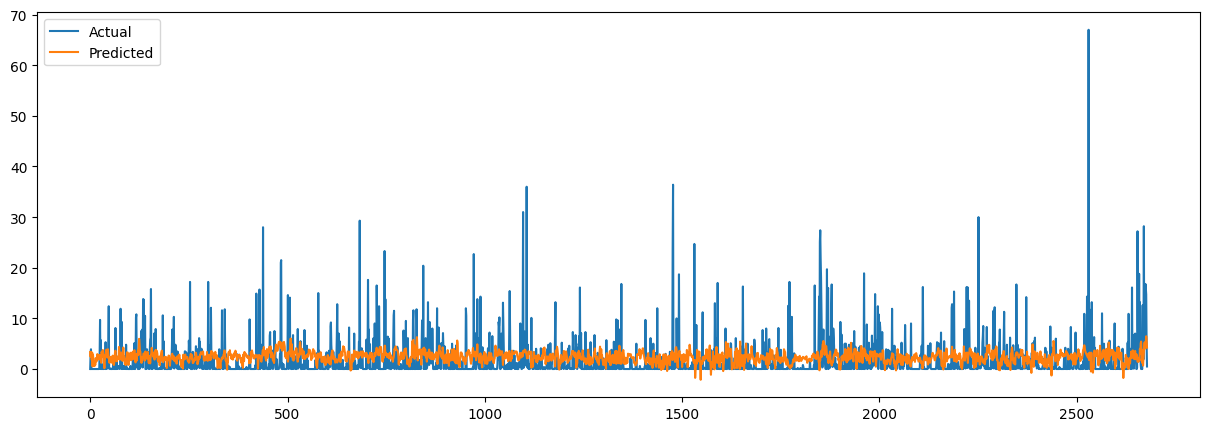

IND.1
Day  1 :
MAE-E1D1 :  0.039905403522734945, MAE-E2D2 :  0.053238188788800954
MAE-CNN :  0.0896220839081437
MSE-E1D1 :  0.015010405731416984, MSE-E2D2 :  0.016633521922046805
MSE-CNN :  0.027505927262271065
R2-E1D1 :  0.1612925280190064, R2-E2D2 :  0.07060079714025347
R2-CNN :  -0.5368956130444786
RMSE-E1D1 :  0.12251696099486382, RMSE-E2D2 :  0.12897101194472657
RMSE-CNN :  0.16584910992305948
Day  2 :
MAE-E1D1 :  0.0349759197626687, MAE-E2D2 :  0.042198861788884615
MAE-CNN :  0.10800472045398639
MSE-E1D1 :  0.02392000934424839, MSE-E2D2 :  0.024083863047633422
MSE-CNN :  0.04166075641009966
R2-E1D1 :  -0.33653219811950175, R2-E2D2 :  -0.3456875352769213
R2-CNN :  -1.32779768346956
RMSE-E1D1 :  0.15466094964226876, RMSE-E2D2 :  0.15518976463553716
RMSE-CNN :  0.20410966760567628
Day  3 :
MAE-E1D1 :  0.036467289648735954, MAE-E2D2 :  0.04307676545271637
MAE-CNN :  0.10757541042426132
MSE-E1D1 :  0.030884953262032205, MSE-E2D2 :  0.0309734485602586
MSE-CNN :  0.04820100954059158
R2-

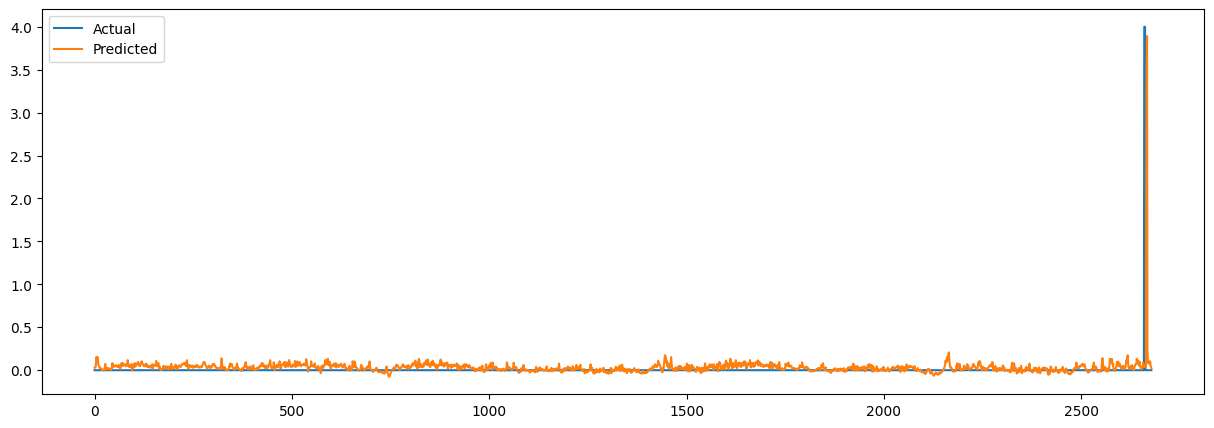

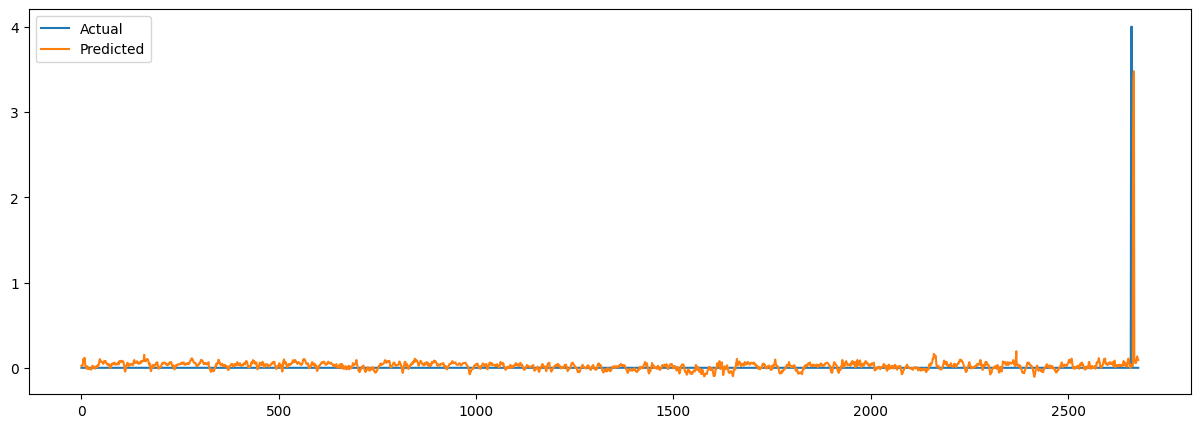

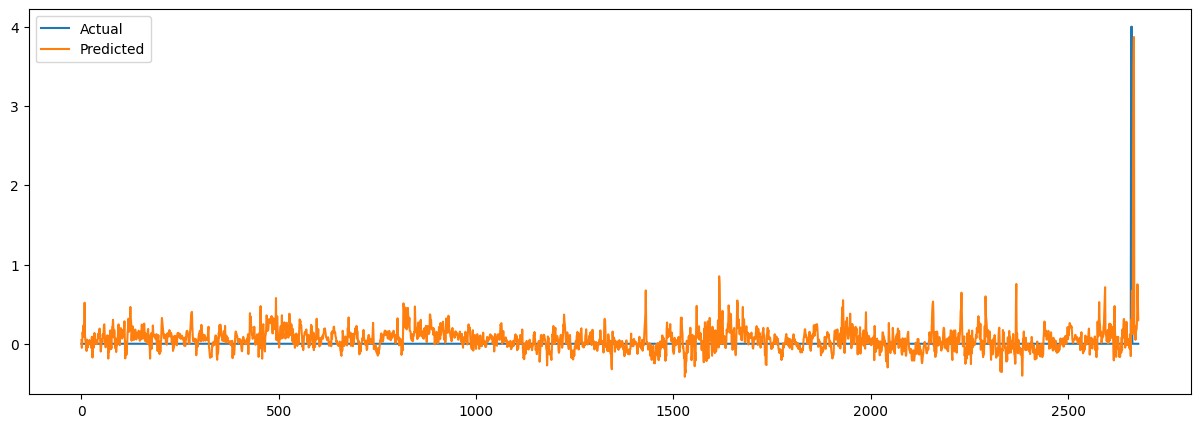

T.MAX
Day  1 :
MAE-E1D1 :  1.6215966781425406, MAE-E2D2 :  1.6026857160907844
MAE-CNN :  1.7220941032567725
MSE-E1D1 :  4.185034049050369, MSE-E2D2 :  4.121953798433855
MSE-CNN :  4.71766820045513
R2-E1D1 :  0.8216888976999271, R2-E2D2 :  0.8243765482396754
R2-CNN :  0.7989950363008311
RMSE-E1D1 :  2.045735576522628, RMSE-E2D2 :  2.030259539673156
RMSE-CNN :  2.1720193830753742
Day  2 :
MAE-E1D1 :  1.9274544997640668, MAE-E2D2 :  1.9367423851394796
MAE-CNN :  2.083949601289807
MSE-E1D1 :  5.836126825573727, MSE-E2D2 :  5.888147058055458
MSE-CNN :  6.783129675327361
R2-E1D1 :  0.7512825949416418, R2-E2D2 :  0.7490656559305338
R2-CNN :  0.7109243062318279
RMSE-E1D1 :  2.4158076963147805, RMSE-E2D2 :  2.4265504441604873
RMSE-CNN :  2.604444216205707
Day  3 :
MAE-E1D1 :  2.051308761652213, MAE-E2D2 :  2.059364903048821
MAE-CNN :  2.2520996184169286
MSE-E1D1 :  6.671938219156176, MSE-E2D2 :  6.746794411317403
MSE-CNN :  8.074862353270849
R2-E1D1 :  0.715839718125616, R2-E2D2 :  0.7126515656

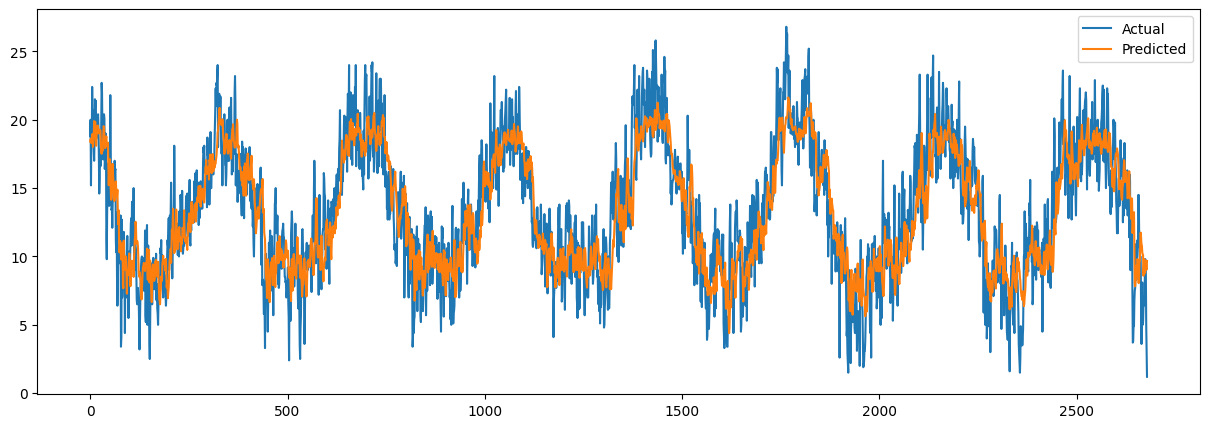

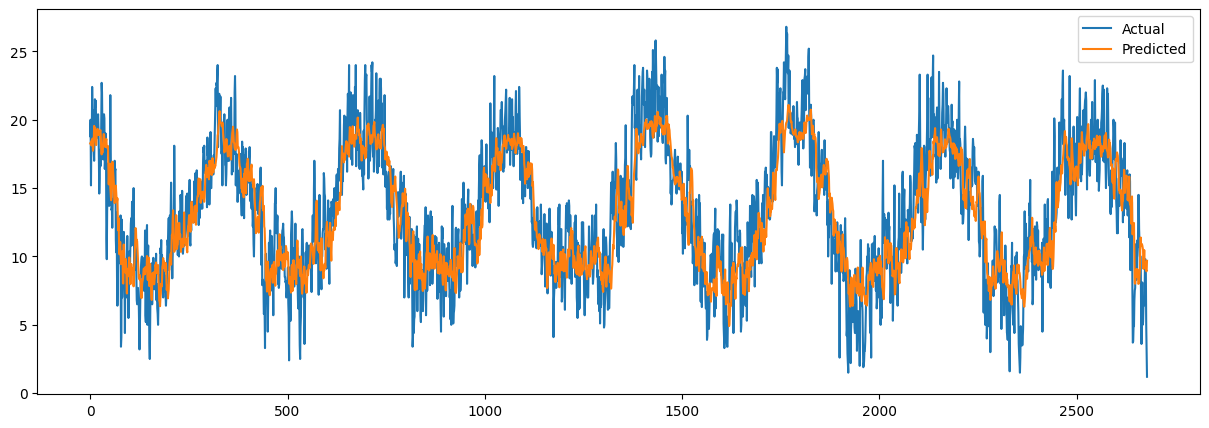

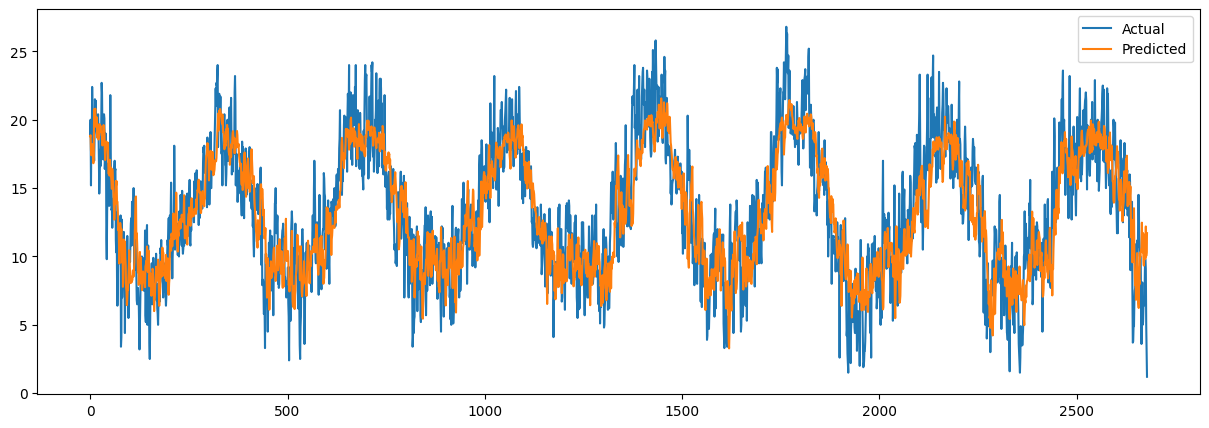

IND.2
Day  1 :
MAE-E1D1 :  0.1297138282370772, MAE-E2D2 :  0.14689967253173453
MAE-CNN :  0.17459627949243697
MSE-E1D1 :  0.06540525074857899, MSE-E2D2 :  0.06589025866797267
MSE-CNN :  0.07643795290457876
R2-E1D1 :  0.27625576826515197, R2-E2D2 :  0.2708888951167522
R2-CNN :  0.15417299273161522
RMSE-E1D1 :  0.2557445028706951, RMSE-E2D2 :  0.256690978937657
RMSE-CNN :  0.27647414509240964
Day  2 :
MAE-E1D1 :  0.14403476199804735, MAE-E2D2 :  0.16934214171387893
MAE-CNN :  0.2005090355294638
MSE-E1D1 :  0.08593757378190765, MSE-E2D2 :  0.08608937929987533
MSE-CNN :  0.1040697461558913
R2-E1D1 :  0.04905458503582183, R2-E2D2 :  0.047374775437706185
R2-CNN :  -0.1515876419153186
RMSE-E1D1 :  0.29315111083178186, RMSE-E2D2 :  0.2934099168396926
RMSE-CNN :  0.3225984286320863
Day  3 :
MAE-E1D1 :  0.15379834922670918, MAE-E2D2 :  0.1846368758257488
MAE-CNN :  0.22083684716397323
MSE-E1D1 :  0.09350915985824897, MSE-E2D2 :  0.09664603952523178
MSE-CNN :  0.1194395250058104
R2-E1D1 :  -0.034

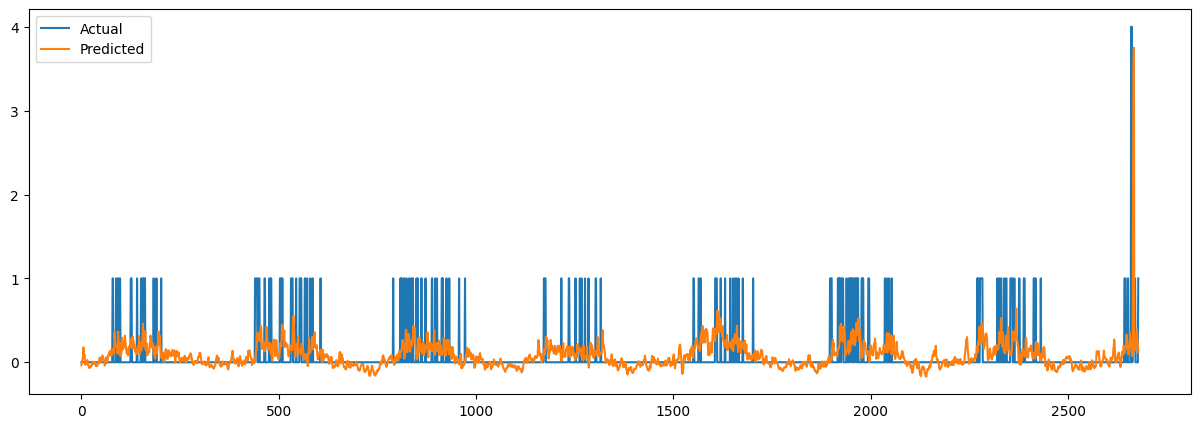

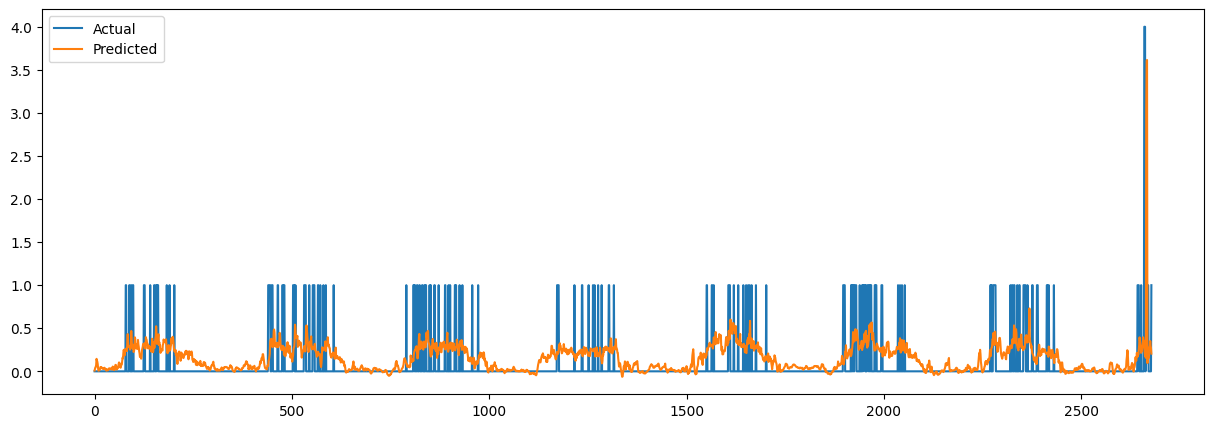

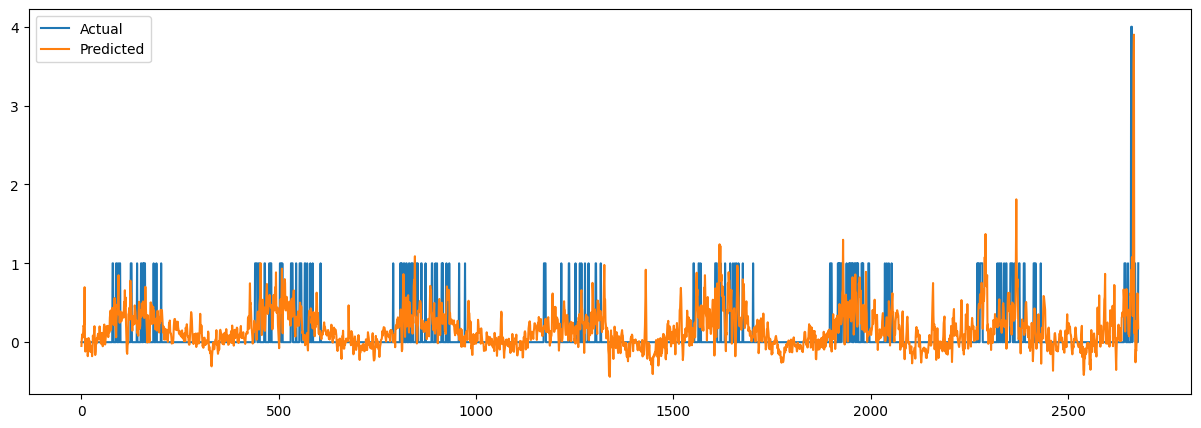

T.MIN
Day  1 :
MAE-E1D1 :  1.9596269372624215, MAE-E2D2 :  1.963581296838834
MAE-CNN :  2.025937777876676
MSE-E1D1 :  5.862005712393982, MSE-E2D2 :  5.757323005271089
MSE-CNN :  6.213511142961757
R2-E1D1 :  0.7192169829022689, R2-E2D2 :  0.724231158559208
R2-CNN :  0.7023802959109233
RMSE-E1D1 :  2.4211579280158455, RMSE-E2D2 :  2.399442227950298
RMSE-CNN :  2.4926915458920615
Day  2 :
MAE-E1D1 :  2.294057105924933, MAE-E2D2 :  2.3070493326386483
MAE-CNN :  2.4030746450599736
MSE-E1D1 :  8.123167628381603, MSE-E2D2 :  8.106026427197738
MSE-CNN :  8.880602315985943
R2-E1D1 :  0.6105609731431261, R2-E2D2 :  0.6113827526524986
R2-CNN :  0.5742482142364085
RMSE-E1D1 :  2.8501171253795174, RMSE-E2D2 :  2.8471084326378824
RMSE-CNN :  2.9800339454418876
Day  3 :
MAE-E1D1 :  2.4300321666100393, MAE-E2D2 :  2.459724219311369
MAE-CNN :  2.5980286232367873
MSE-E1D1 :  9.264910763646398, MSE-E2D2 :  9.37043741430192
MSE-CNN :  10.714860573771597
R2-E1D1 :  0.5554068250075048, R2-E2D2 :  0.55034294

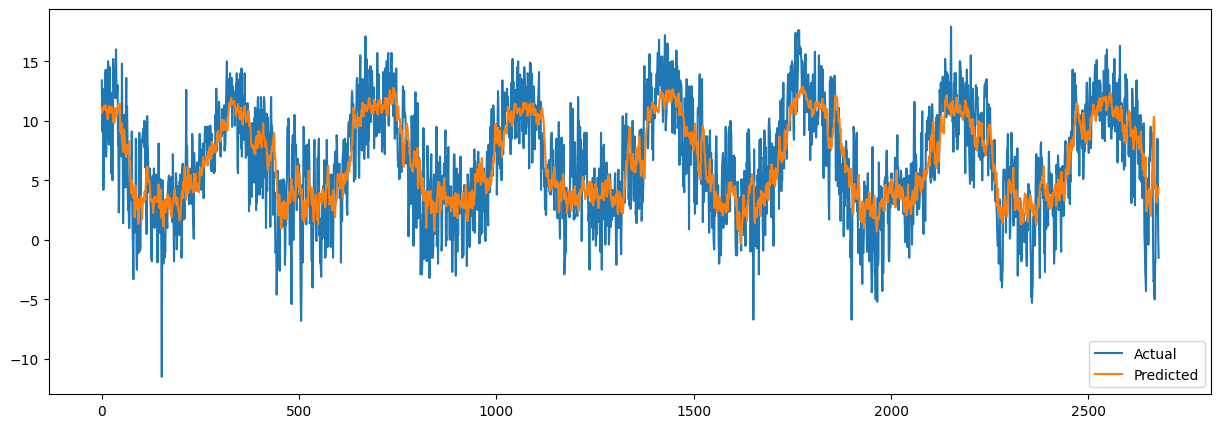

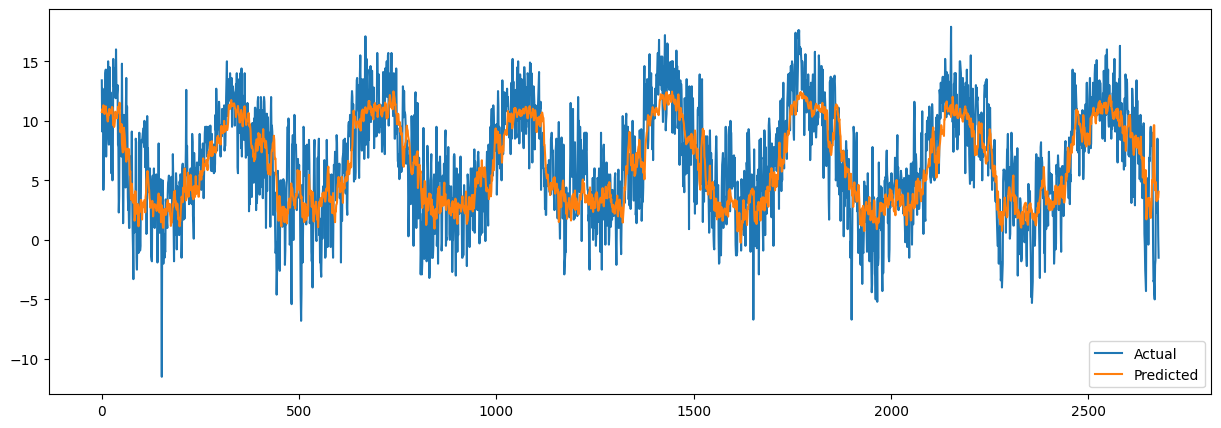

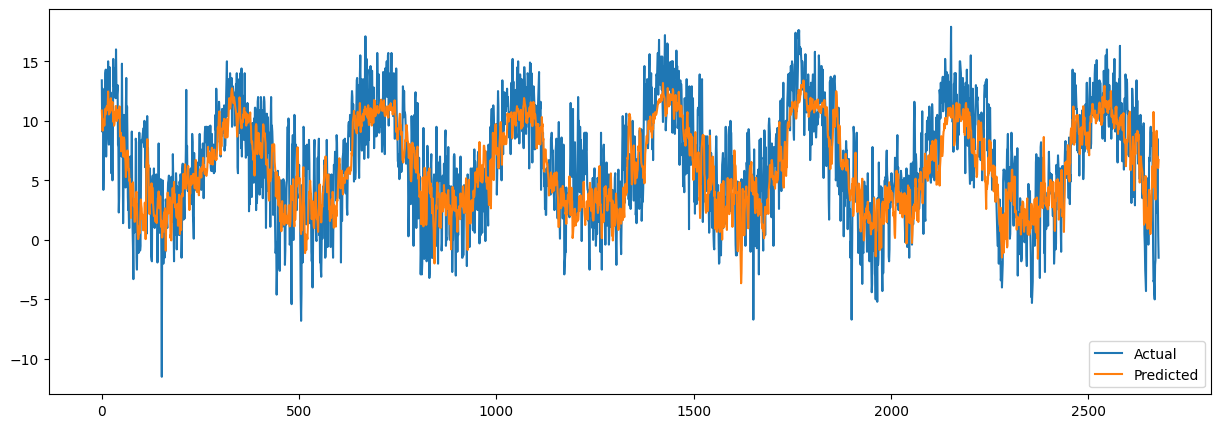

T.MIN.G
Day  1 :
MAE-E1D1 :  3.0780430794291616, MAE-E2D2 :  3.0551746868641168
MAE-CNN :  3.009453670371681
MSE-E1D1 :  13.862538294636659, MSE-E2D2 :  13.509409949020949
MSE-CNN :  13.517509718517355
R2-E1D1 :  0.5462309588824541, R2-E2D2 :  0.5577900765112552
R2-CNN :  0.5575249429145401
RMSE-E1D1 :  3.7232429808752285, RMSE-E2D2 :  3.675514922976228
RMSE-CNN :  3.6766166129360505
Day  2 :
MAE-E1D1 :  3.377152770949889, MAE-E2D2 :  3.3724077313557514
MAE-CNN :  3.4238333453651846
MSE-E1D1 :  16.792027248749974, MSE-E2D2 :  16.533568975006087
MSE-CNN :  17.395279816417208
R2-E1D1 :  0.44966051023575315, R2-E2D2 :  0.45813118458557867
R2-CNN :  0.42988959720834186
RMSE-E1D1 :  4.097807614902141, RMSE-E2D2 :  4.0661491579879465
RMSE-CNN :  4.17076489584551
Day  3 :
MAE-E1D1 :  3.4631949403505438, MAE-E2D2 :  3.469643136932626
MAE-CNN :  3.5610218480622446
MSE-E1D1 :  17.66091030185279, MSE-E2D2 :  17.54780065156348
MSE-CNN :  18.942388175228665
R2-E1D1 :  0.4202636856103904, R2-E2D2 : 

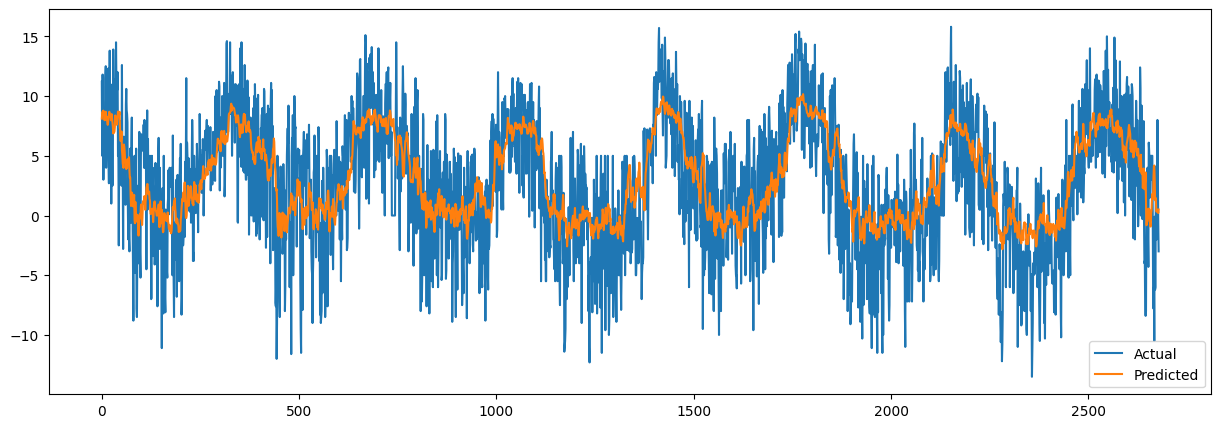

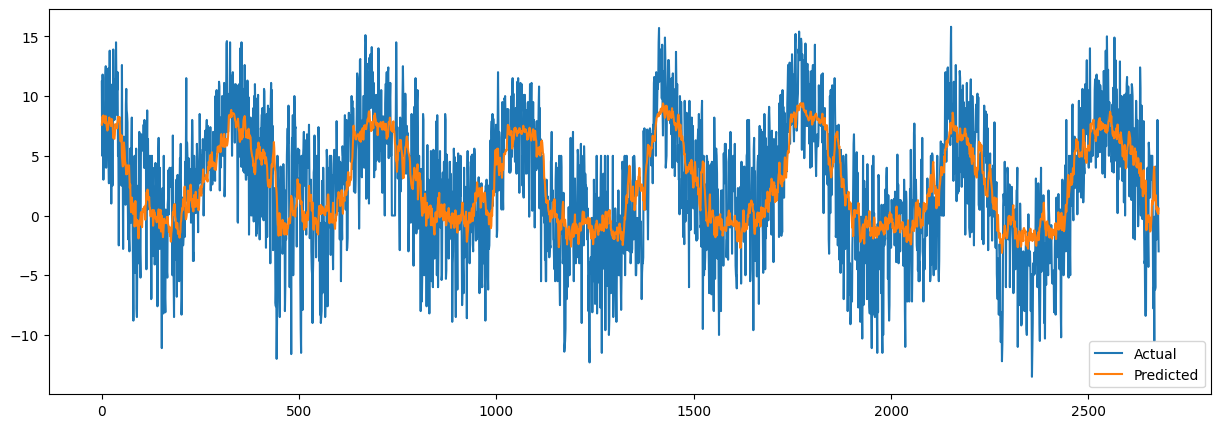

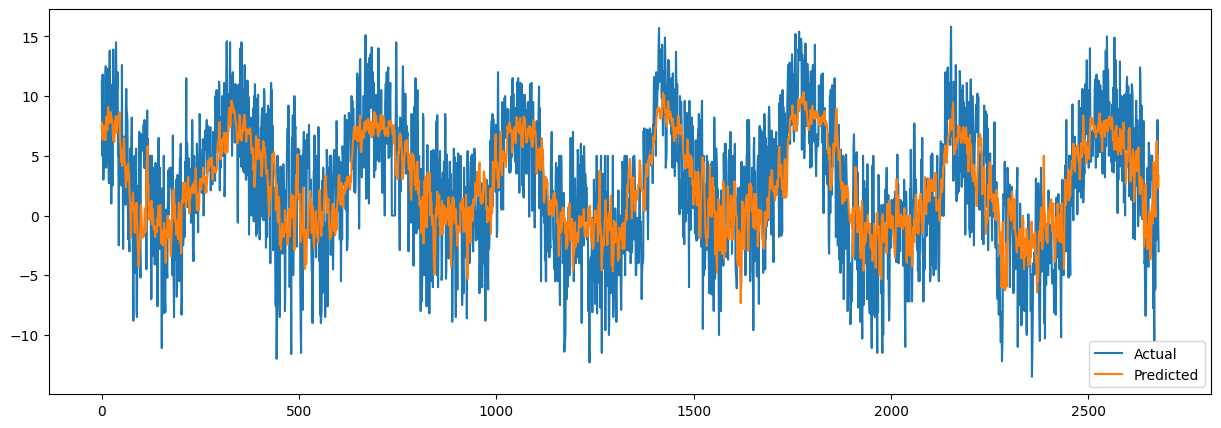

In [25]:
# Fit and transform the training data
for i in train.columns:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    s_s = scaler.fit_transform(train[[i]])
    train.loc[:, i] = s_s.reshape(-1)
    scalers['scaler_' + i] = scaler

# Transform the test data using the same scalers

for i in test.columns:
    scaler = scalers['scaler_' + i]
    s_s = scaler.transform(test[[i]])
    test.loc[:, i] = s_s.reshape(-1)
def split_series(series, n_past, n_future):

  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end,
                          :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

n_features = 8
lstm_units = 100

X_train, y_train = split_series(train.values, n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
# E1D1


def create_LSTM_E1D1(n_past, n_features, n_future, lstm_units=100):
    # Encoder
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
    encoder_l1 = tf.keras.layers.LSTM(lstm_units, return_state=True)
    encoder_outputs1, state_h1, state_c1 = encoder_l1(encoder_inputs)
    encoder_states1 = [state_h1, state_c1]

    # Decoder
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1)
    decoder_l1 = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(
        decoder_inputs, initial_state=encoder_states1)
    decoder_outputs1 = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(n_features))(decoder_l1)

    # Model
    model = tf.keras.models.Model(encoder_inputs, decoder_outputs1)
    return model


# Create the model
model_e1d1 = create_LSTM_E1D1(n_past, n_features, n_future, lstm_units)

# Compile the model before calling summary and plot_model
model_e1d1.compile(optimizer='adam', loss='mse')

# Display model summary
model_e1d1.summary()

# E2D2


def create_LSTM_E2D2(n_past, n_features, n_future, lstm_units=100):
    # Encoder
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
    encoder_l1 = tf.keras.layers.LSTM(
        lstm_units, return_sequences=True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]

    encoder_l2 = tf.keras.layers.LSTM(lstm_units, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]

    # Decoder
    decoder_inputs = tf.keras.layers.RepeatVector(
        n_future)(encoder_outputs2[0])

    decoder_l1 = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(
        decoder_inputs, initial_state=encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(
        decoder_l1, initial_state=encoder_states2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(n_features))(decoder_l2)

    # Model
    model = tf.keras.models.Model(encoder_inputs, decoder_outputs2)
    return model


# Create the model
model_e2d2 = create_LSTM_E2D2(n_past, n_features, n_future, lstm_units)

# Compile the model before calling summary and plot_model
model_e2d2.compile(optimizer='adam', loss='mse')

# Display model summary
model_e2d2.summary()


# CNN


def create_CNN(n_past, n_features, n_future, cnn_filters=64, kernel_size=3):
    # Encoder
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
    encoder_conv1 = tf.keras.layers.Conv1D(
        filters=cnn_filters, kernel_size=kernel_size, activation='relu', padding='same')(encoder_inputs)
    encoder_conv2 = tf.keras.layers.Conv1D(
        filters=cnn_filters, kernel_size=kernel_size, activation='relu', padding='same')(encoder_conv1)

    # Flatten the encoder's output for the RepeatVector layer
    encoder_flat = tf.keras.layers.Flatten()(encoder_conv2)
    encoder_repeat = tf.keras.layers.RepeatVector(n_future)(encoder_flat)

    # Decoder
    decoder_conv1 = tf.keras.layers.Conv1D(
        filters=cnn_filters, kernel_size=kernel_size, activation='relu', padding='same')(encoder_repeat)
    decoder_conv2 = tf.keras.layers.Conv1D(
        filters=cnn_filters, kernel_size=kernel_size, activation='relu', padding='same')(decoder_conv1)
    decoder_outputs = tf.keras.layers.Conv1D(
        filters=n_features, kernel_size=kernel_size, activation='linear', padding='same')(decoder_conv2)

    # Reshape the decoder's output to match the target shape
    decoder_reshaped = tf.keras.layers.Reshape(
        (n_future, n_features))(decoder_outputs)

    # Model
    model = tf.keras.models.Model(encoder_inputs, decoder_reshaped)
    return model


# Define model parameters

cnn_filters = 64  # Number of CNN filters
kernel_size = 3  # Kernel size for Conv1D layers

# Create the model
model_cnn = create_CNN(n_past, n_features, n_future, cnn_filters, kernel_size)

# Compile the model before calling summary and plot_model
model_cnn.compile(optimizer='adam', loss='mse')

# Display model summary
model_cnn.summary()

# Plot model and display
plot_model(model_cnn, to_file="model_with_shape_info_cnn.png",
           show_shapes=True, show_layer_names=True)
display(Image(filename="model_with_shape_info_cnn.png"))

reduce_lr = tf.keras.callbacks.LearningRateScheduler(
    lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.Huber())
history_e1d1 = model_e1d1.fit(X_train, y_train, epochs=25, validation_data=(
    X_test, y_test), batch_size=32, verbose=0, callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.Huber())
history_e2d2 = model_e2d2.fit(X_train, y_train, epochs=25, validation_data=(
    X_test, y_test), batch_size=32, verbose=0, callbacks=[reduce_lr])

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.Huber())
history_cnn = model_cnn.fit(X_train, y_train, epochs=25, validation_data=(
    X_test, y_test), batch_size=32, verbose=0, callbacks=[reduce_lr])


model_e1d1.summary()
model_e2d2.summary()
model_cnn.summary()
pred_e1d1 = model_e1d1.predict(X_test)
pred_e2d2 = model_e2d2.predict(X_test)
pred_cnn = model_cnn.predict(X_test)


plt.plot(history_e1d1.history['loss'], label='lstm train', color='brown')
plt.plot(history_e1d1.history['val_loss'], label='lstm test', color='blue')
plt.legend()
plt.show()


plt.plot(history_e2d2.history['loss'], label='lstm train', color='brown')
plt.plot(history_e2d2.history['val_loss'], label='lstm test', color='blue')
plt.legend()
plt.show()


plt.plot(history_cnn.history['loss'], label='CNN train', color='brown')
plt.plot(history_cnn.history['val_loss'], label='CNN test', color='blue')
plt.legend()
plt.show()

for index, i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_e1d1[:, :, index] = scaler.inverse_transform(pred_e1d1[:, :, index])
    pred_e2d2[:, :, index] = scaler.inverse_transform(pred_e2d2[:, :, index])
    pred_cnn[:, :, index] = scaler.inverse_transform(pred_cnn[:, :, index])
    y_train[:, :, index] = scaler.inverse_transform(y_train[:, :, index])
    y_test[:, :, index] = scaler.inverse_transform(y_test[:, :, index])


plt.rcParams['figure.figsize'] = (15, 5)


for index, i in enumerate(train_df.columns):

  print(i)
  for j in range(1, 6):

    print("Day ", j, ":")

    print("MAE-E1D1 : ",
          mean_absolute_error(y_test[:, j-1, index], pred_e1d1[:, j-1, index]), end=", ")

    print("MAE-E2D2 : ",
          mean_absolute_error(y_test[:, j-1, index], pred_e2d2[:, j-1, index]))
    print("MAE-CNN : ",
          mean_absolute_error(y_test[:, j-1, index], pred_cnn[:, j-1, index]))
    print("MSE-E1D1 : ",
          mean_squared_error(y_test[:, j-1, index], pred_e1d1[:, j-1, index]), end=", ")
    print("MSE-E2D2 : ",
          mean_squared_error(y_test[:, j-1, index], pred_e2d2[:, j-1, index]))
    print("MSE-CNN : ",
          mean_squared_error(y_test[:, j-1, index], pred_cnn[:, j-1, index]))
    print("R2-E1D1 : ",
          r2_score(y_test[:, j-1, index], pred_e1d1[:, j-1, index]), end=", ")
    print("R2-E2D2 : ",
          r2_score(y_test[:, j-1, index], pred_e2d2[:, j-1, index]))
    print("R2-CNN : ",
          r2_score(y_test[:, j-1, index], pred_cnn[:, j-1, index]))
    print("RMSE-E1D1 : ",
          sqrt(mean_squared_error(y_test[:, j-1, index], pred_e1d1[:, j-1, index])), end=", ")
    print("RMSE-E2D2 : ",
          sqrt(mean_squared_error(y_test[:, j-1, index], pred_e2d2[:, j-1, index])))
    print("RMSE-CNN : ",
          sqrt(mean_squared_error(y_test[:, j-1, index], pred_cnn[:, j-1, index])))
  print()

  print()
  # plotting predicted test value vs actual test value for Sequence to Sequence Model with one encoder layer and one decoder layer
  plt.plot(y_test[:, j-1, index], label='Actual')
  plt.plot(pred_e1d1[:, j-1, index], label='Predicted')
  plt.legend()
  plt.show()
  # plotting predicted test value vs actual test value for Sequence to Sequence Model with two encoder layers and two decoder layers.
  plt.plot(y_test[:, j-1, index], label='Actual')
  plt.plot(pred_e2d2[:, j-1, index], label='Predicted')
  plt.legend()
  plt.show()
  # plotting predicted test value vs actual test value for Sequence to Sequence Model with two encoder layers and two decoder layers.
  plt.plot(y_test[:, j-1, index], label='Actual')
  plt.plot(pred_cnn[:, j-1, index], label='Predicted')
  plt.legend()
  plt.show()

### Shallow Model: MLP regressor and SVR

WIND
Day  1 :
MAE-MLP :  3.0259601151997275, MAE-SVR :  3.661856398896277
MSE-MLP :  14.829209462357536, MSE-SVR :  21.270185371444924
R2-MLP :  0.35383384069806345, R2-SVR :  0.07317554425306638
RMSE-MLP :  3.8508712601640602, RMSE-SVR :  4.611961119897361
Day  2 :
MAE-MLP :  3.494005403278779, MAE-SVR :  4.3363493089598295
MSE-MLP :  19.579557673594174, MSE-SVR :  29.344948165228047
R2-MLP :  0.1471535859760199, R2-SVR :  -0.27820731344643357
RMSE-MLP :  4.424879396502709, RMSE-SVR :  5.417097762199612
Day  3 :
MAE-MLP :  3.6168179078562392, MAE-SVR :  4.492889419873096
MSE-MLP :  20.82989040015143, MSE-SVR :  31.749320146797583
R2-MLP :  0.09299352892616919, R2-SVR :  -0.38247673281712546
RMSE-MLP :  4.563977475859344, RMSE-SVR :  5.634653507252915
Day  4 :
MAE-MLP :  3.653716955626054, MAE-SVR :  4.547804962623408
MSE-MLP :  21.25687989785448, MSE-SVR :  32.57352740228185
R2-MLP :  0.07572371689388402, R2-SVR :  -0.4163385680169869
RMSE-MLP :  4.610518397952065, RMSE-SVR :  5.70732

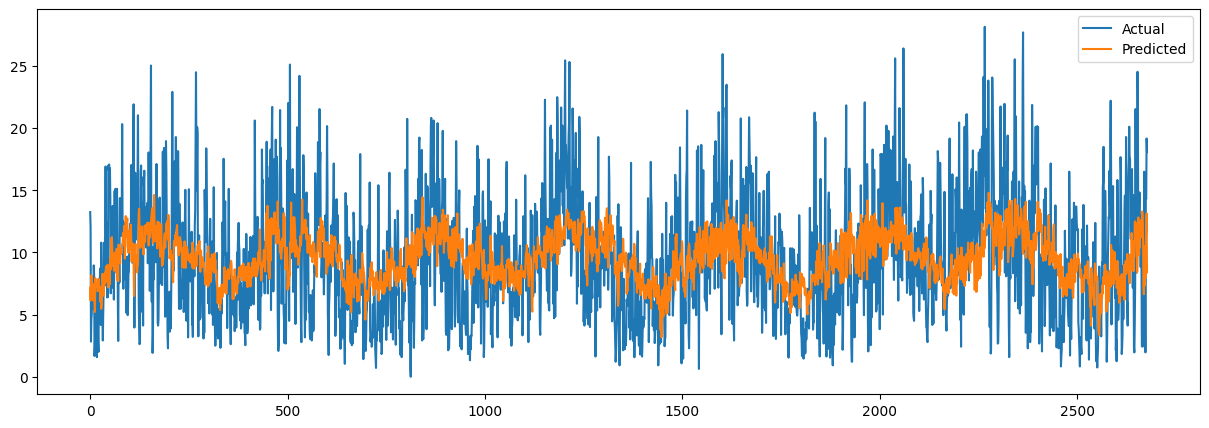

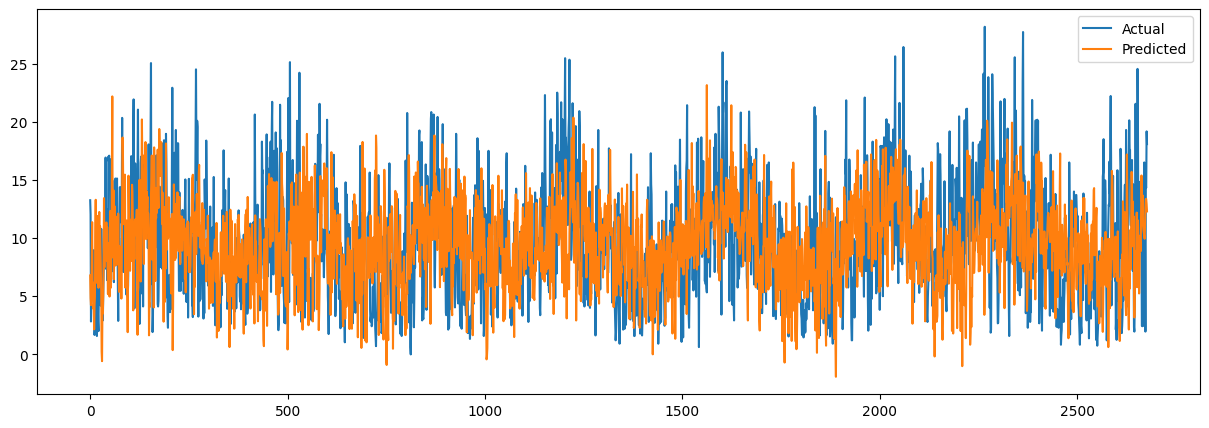

IND
Day  1 :
MAE-MLP :  0.7999369781159728, MAE-SVR :  1.0424544009241925
MSE-MLP :  2.062632034226273, MSE-SVR :  2.5565373472609765
R2-MLP :  -0.016327152787875887, R2-SVR :  -0.25969066708123445
RMSE-MLP :  1.4361866293160765, RMSE-SVR :  1.5989175548667218
Day  2 :
MAE-MLP :  0.7778410697357597, MAE-SVR :  1.081720841010631
MSE-MLP :  2.207425107973333, MSE-SVR :  2.713417301524729
R2-MLP :  -0.0876714982372353, R2-SVR :  -0.336990619084637
RMSE-MLP :  1.4857405924229616, RMSE-SVR :  1.6472453677350951
Day  3 :
MAE-MLP :  0.8004917984252187, MAE-SVR :  1.080482300624789
MSE-MLP :  2.167908202232, MSE-SVR :  2.71967836335849
R2-MLP :  -0.06820020930511084, R2-SVR :  -0.34007565172320064
RMSE-MLP :  1.4723818126532262, RMSE-SVR :  1.6491447369344179
Day  4 :
MAE-MLP :  0.7937016714091558, MAE-SVR :  1.1121325823671722
MSE-MLP :  2.1762886010861555, MSE-SVR :  2.828256616137692
R2-MLP :  -0.07232950952218298, R2-SVR :  -0.393575754829649
RMSE-MLP :  1.4752249323700286, RMSE-SVR :  1.6

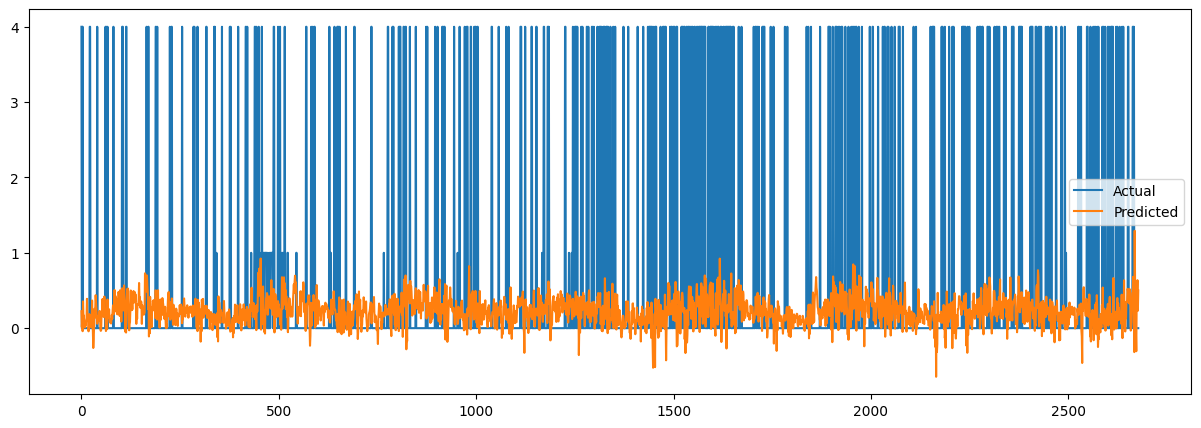

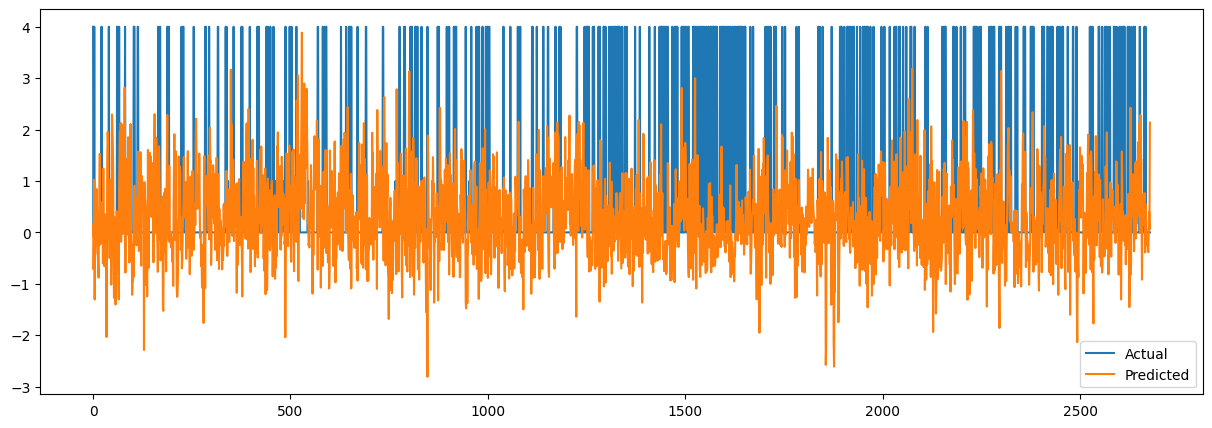

RAIN
Day  1 :
MAE-MLP :  2.379281812182808, MAE-SVR :  3.3090121357894615
MSE-MLP :  15.534747342211867, MSE-SVR :  22.658037708591124
R2-MLP :  -0.04344708337602943, R2-SVR :  -0.5219084572950152
RMSE-MLP :  3.9414143834684356, RMSE-SVR :  4.760045977571133
Day  2 :
MAE-MLP :  2.6307634534456814, MAE-SVR :  3.5240767749386315
MSE-MLP :  16.671188265889846, MSE-SVR :  24.858767489669496
R2-MLP :  -0.11484533440982991, R2-SVR :  -0.6623698630853139
RMSE-MLP :  4.083036647630027, RMSE-SVR :  4.985856745803021
Day  3 :
MAE-MLP :  2.2021899054133964, MAE-SVR :  3.5801723895729856
MSE-MLP :  15.578933271898764, MSE-SVR :  25.995701018169022
R2-MLP :  -0.03662895434241209, R2-SVR :  -0.7297651831188641
RMSE-MLP :  3.9470157425450894, RMSE-SVR :  5.098597946315146
Day  4 :
MAE-MLP :  2.366343665685046, MAE-SVR :  3.5966381607633133
MSE-MLP :  16.521790320164968, MSE-SVR :  26.277369306924935
R2-MLP :  -0.09501158960893408, R2-SVR :  -0.7415802632719521
RMSE-MLP :  4.064700520353863, RMSE-SVR 

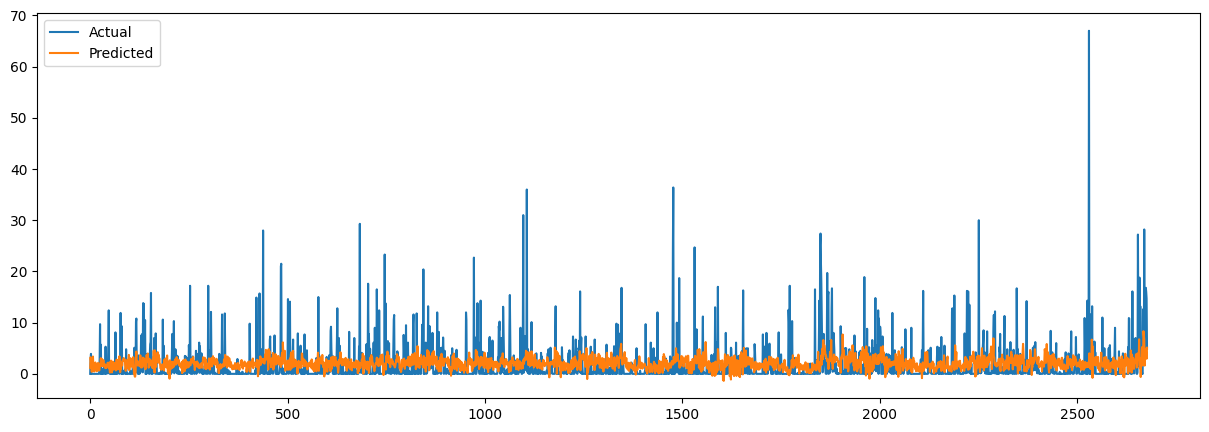

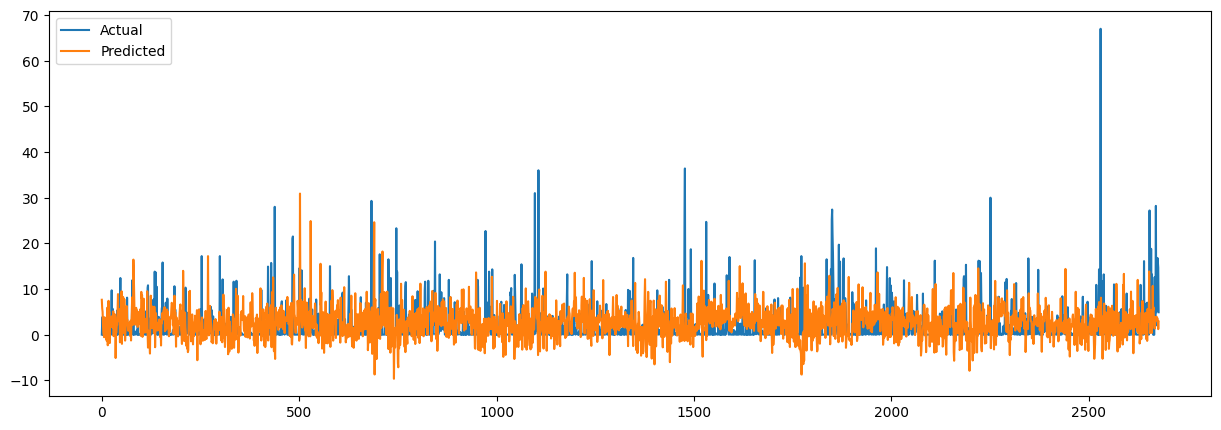

IND.1
Day  1 :
MAE-MLP :  0.1075975569571274, MAE-SVR :  0.2417858014526619
MSE-MLP :  0.031565750482179245, MSE-SVR :  0.1131323742577525
R2-MLP :  -0.7630809009426576, R2-SVR :  -5.318922417027537
RMSE-MLP :  0.17766752793400162, RMSE-SVR :  0.3363515634834369
Day  2 :
MAE-MLP :  0.0988820738064209, MAE-SVR :  0.2748215468532306
MSE-MLP :  0.03420420374972766, MSE-SVR :  0.15021573490361048
R2-MLP :  -0.9104496944288312, R2-SVR :  -7.390185222402376
RMSE-MLP :  0.18494378537741585, RMSE-SVR :  0.3875767471141819
Day  3 :
MAE-MLP :  0.10483027056082586, MAE-SVR :  0.30442875546083326
MSE-MLP :  0.043795605987328165, MSE-SVR :  0.1810801432528553
R2-MLP :  -1.4461701458693592, R2-SVR :  -9.114093193802264
RMSE-MLP :  0.20927399739893193, RMSE-SVR :  0.42553512575679964
Day  4 :
MAE-MLP :  0.10806402429213555, MAE-SVR :  0.3349868887061579
MSE-MLP :  0.04640340360171458, MSE-SVR :  0.21251168112706606
R2-MLP :  -1.5918266912457861, R2-SVR :  -10.869677751963255
RMSE-MLP :  0.21541449255

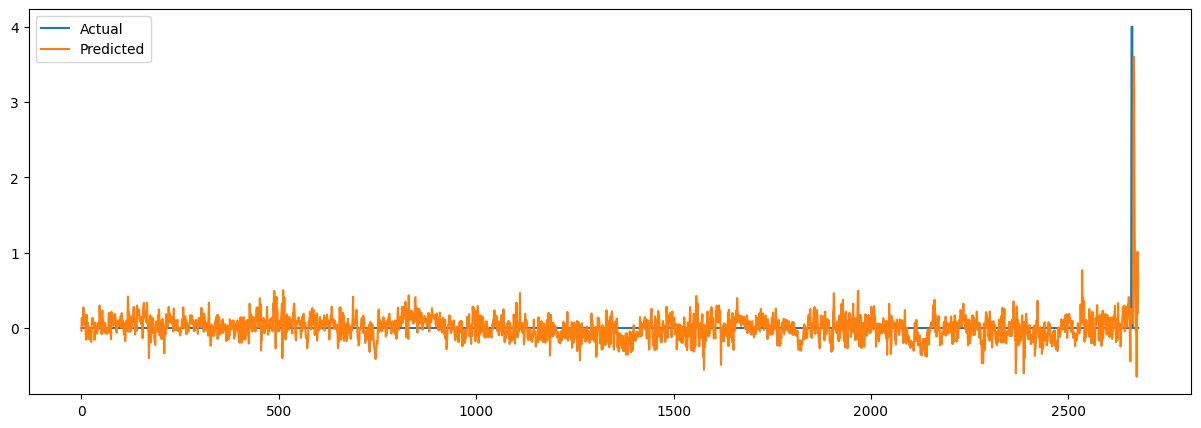

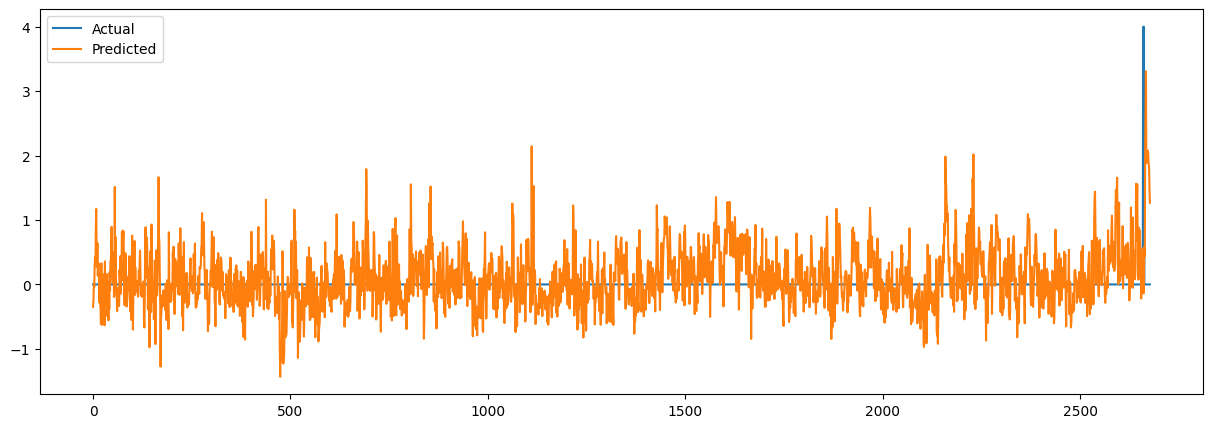

T.MAX
Day  1 :
MAE-MLP :  1.6837765791910315, MAE-SVR :  1.937934527555254
MSE-MLP :  4.517931331373903, MSE-SVR :  5.912391975477385
R2-MLP :  0.8075381730557404, R2-SVR :  0.7481347816623589
RMSE-MLP :  2.1255425969323465, RMSE-SVR :  2.4315410700782714
Day  2 :
MAE-MLP :  2.006012140778102, MAE-SVR :  2.2989221651150435
MSE-MLP :  6.358422304001868, MSE-SVR :  8.260731015604566
R2-MLP :  0.7290469232741266, R2-SVR :  0.6479833553562206
RMSE-MLP :  2.52159122460439, RMSE-SVR :  2.8741487462559356
Day  3 :
MAE-MLP :  2.1276381421307122, MAE-SVR :  2.4449332855650994
MSE-MLP :  7.219891645853703, MSE-SVR :  9.352342933485474
R2-MLP :  0.6922754012752028, R2-SVR :  0.6013865418608768
RMSE-MLP :  2.6869856058143857, RMSE-SVR :  3.0581600568782323
Day  4 :
MAE-MLP :  2.2287657128666627, MAE-SVR :  2.5498056917156515
MSE-MLP :  7.8145436956231435, MSE-SVR :  10.215253162061872
R2-MLP :  0.6671953528756649, R2-SVR :  0.5649542882727903
RMSE-MLP :  2.7954505353561783, RMSE-SVR :  3.196130967

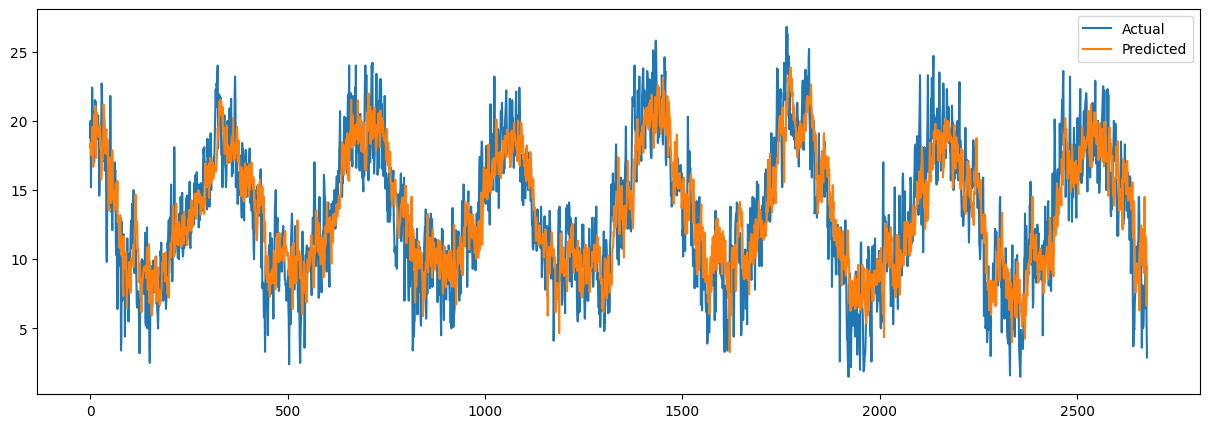

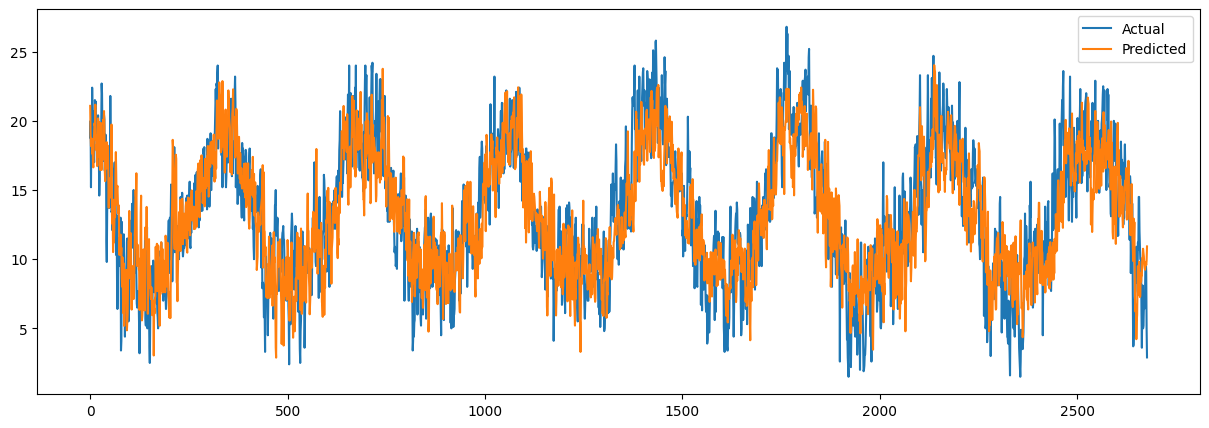

IND.2
Day  1 :
MAE-MLP :  0.1720467016742169, MAE-SVR :  0.2887274382336012
MSE-MLP :  0.07448910825507961, MSE-SVR :  0.1569188220933481
R2-MLP :  0.17602166502827654, R2-SVR :  -0.7357934976404272
RMSE-MLP :  0.2729269284168926, RMSE-SVR :  0.39612980460115355
Day  2 :
MAE-MLP :  0.18868156664810773, MAE-SVR :  0.34015447545684474
MSE-MLP :  0.09637405562080742, MSE-SVR :  0.21608284283636298
R2-MLP :  -0.06606369367416853, R2-SVR :  -1.390249866417503
RMSE-MLP :  0.3104417105042546, RMSE-SVR :  0.4648471177025442
Day  3 :
MAE-MLP :  0.21200643201645372, MAE-SVR :  0.38101149447495897
MSE-MLP :  0.11028205809516865, MSE-SVR :  0.26733913506634144
R2-MLP :  -0.2199102490975957, R2-SVR :  -1.9572330847405883
RMSE-MLP :  0.33208742537947544, RMSE-SVR :  0.5170484842510821
Day  4 :
MAE-MLP :  0.22651787305555895, MAE-SVR :  0.40958280064546604
MSE-MLP :  0.11885521930882316, MSE-SVR :  0.30790199852182704
R2-MLP :  -0.3147442358071828, R2-SVR :  -2.40592849101775
RMSE-MLP :  0.3447538532

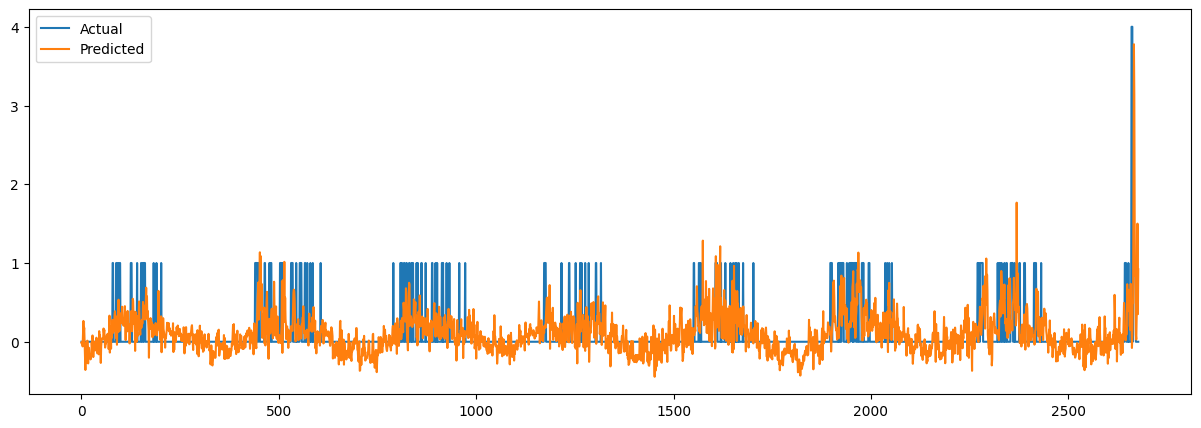

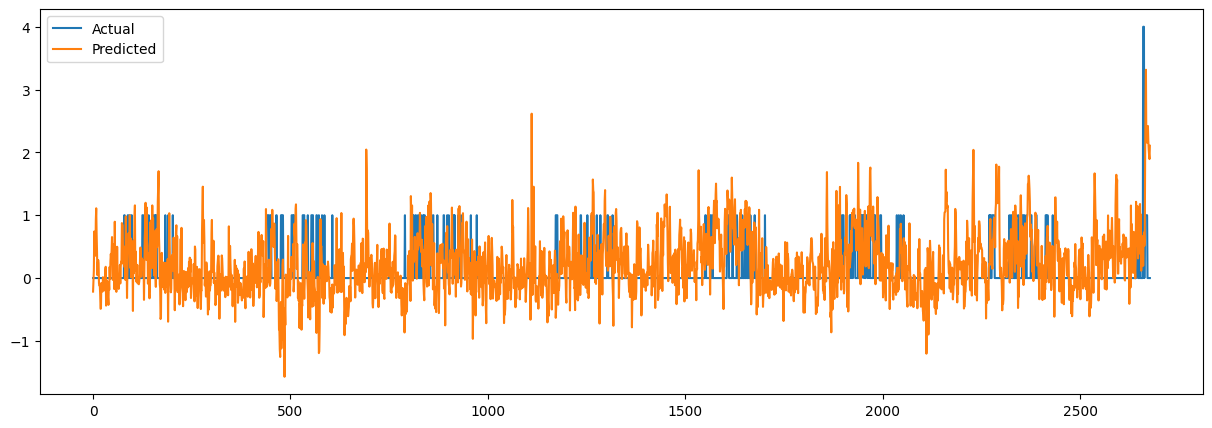

T.MIN
Day  1 :
MAE-MLP :  1.976964865924387, MAE-SVR :  2.2087417531545617
MSE-MLP :  5.914746705021704, MSE-SVR :  7.532686007880189
R2-MLP :  0.7167597527492318, R2-SVR :  0.6392812822359806
RMSE-MLP :  2.432025227052899, RMSE-SVR :  2.7445739210085396
Day  2 :
MAE-MLP :  2.4329771161880775, MAE-SVR :  2.6240252933031063
MSE-MLP :  9.046345173310822, MSE-SVR :  10.62120133989427
R2-MLP :  0.5664387071277444, R2-SVR :  0.4909610791364756
RMSE-MLP :  3.0077142772063343, RMSE-SVR :  3.2590184626501073
Day  3 :
MAE-MLP :  2.499500203146199, MAE-SVR :  2.7961340382363207
MSE-MLP :  9.789934440774601, MSE-SVR :  12.141228783001898
R2-MLP :  0.5303024936849868, R2-SVR :  0.4174930468150466
RMSE-MLP :  3.1288870930052113, RMSE-SVR :  3.4844266074925296
Day  4 :
MAE-MLP :  2.5734360065812347, MAE-SVR :  2.867344776133917
MSE-MLP :  10.224221454656986, MSE-SVR :  12.843004850659849
R2-MLP :  0.5093767005373788, R2-SVR :  0.3837107849443995
RMSE-MLP :  3.1975336518412103, RMSE-SVR :  3.58371383

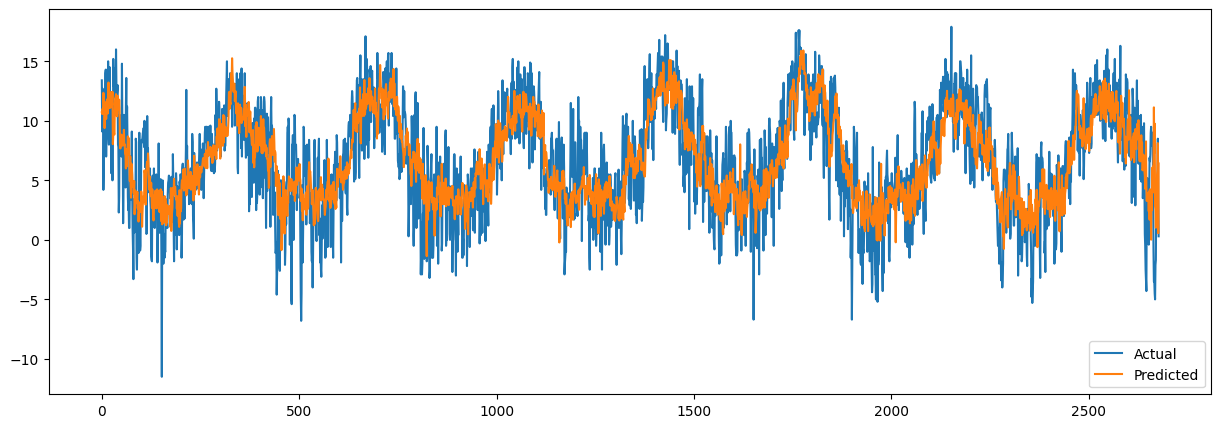

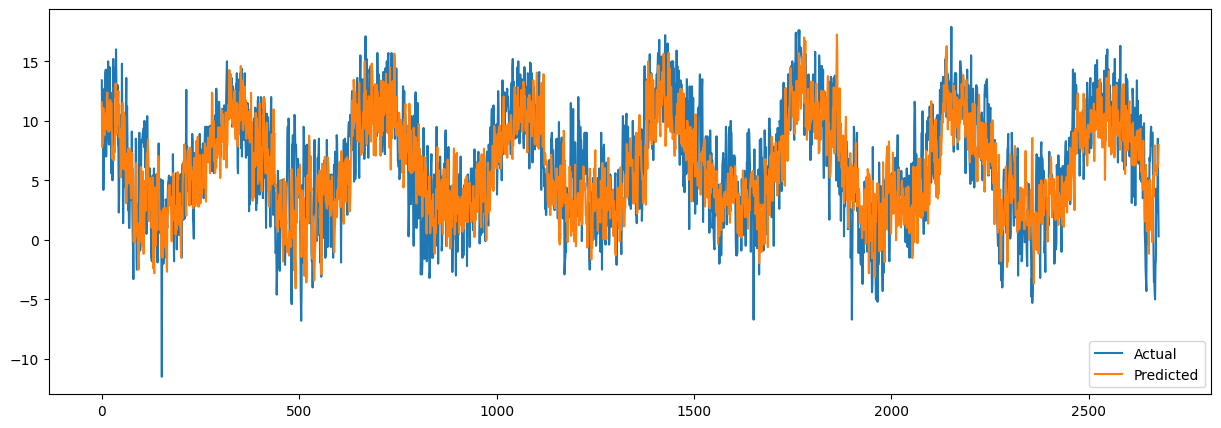

T.MIN.G
Day  1 :
MAE-MLP :  3.0418750456347223, MAE-SVR :  3.3503485364594354
MSE-MLP :  13.840288732440245, MSE-SVR :  17.159102503298524
R2-MLP :  0.5470910181963984, R2-SVR :  0.43848630663196164
RMSE-MLP :  3.720253853225643, RMSE-SVR :  4.142354705152436
Day  2 :
MAE-MLP :  3.3978039040988484, MAE-SVR :  3.8049932384043643
MSE-MLP :  17.066659942106657, MSE-SVR :  21.814241139799844
R2-MLP :  0.440668576353227, R2-SVR :  0.2850744906216167
RMSE-MLP :  4.131181422076094, RMSE-SVR :  4.670571821501072
Day  3 :
MAE-MLP :  3.492739115027091, MAE-SVR :  3.9259165842936485
MSE-MLP :  17.983692906845864, MSE-SVR :  23.488260307549638
R2-MLP :  0.4098857127133594, R2-SVR :  0.229259637450973
RMSE-MLP :  4.24071844229794, RMSE-SVR :  4.8464688493324335
Day  4 :
MAE-MLP :  3.532842345757869, MAE-SVR :  3.962466158806477
MSE-MLP :  18.520913214958256, MSE-SVR :  23.832590038724465
R2-MLP :  0.3919146662474504, R2-SVR :  0.21751976807596518
RMSE-MLP :  4.303593058707834, RMSE-SVR :  4.8818633

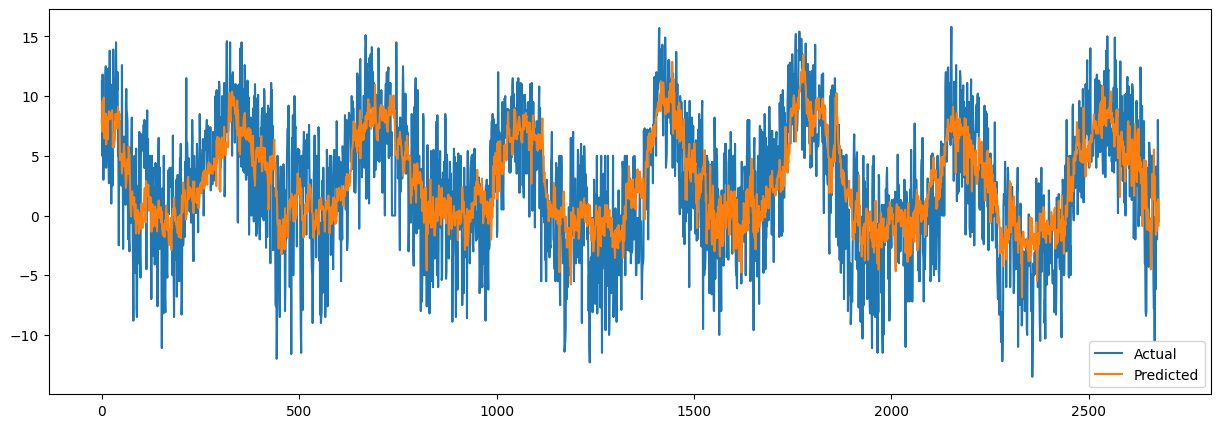

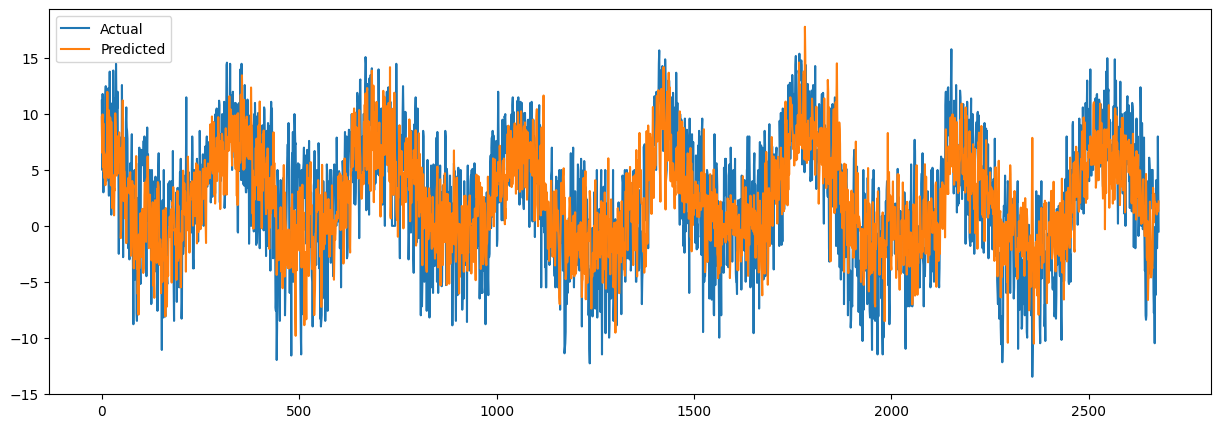

In [26]:
# Function to prepare data for MLP and SVR


def prepare_flat_data(X, y):
    X_flat = X.reshape(X.shape[0], -1)
    y_flat = y.reshape(y.shape[0], -1)
    return X_flat, y_flat


def create_sliding_window_data(data, n_past, n_future):
    X, y = [], []
    for i in range(len(data) - n_past - n_future):
        X.append(data[i:i + n_past])
        y.append(data[i + n_past:i + n_past + n_future])
    X, y = np.array(X), np.array(y)
    return X, y


# Prepare the data
X_train, y_train = create_sliding_window_data(train.values, n_past, n_future)
X_test, y_test = create_sliding_window_data(test.values, n_past, n_future)

# Flatten the data for MLP and SVR
X_train_flat, y_train_flat = prepare_flat_data(X_train, y_train)
X_test_flat, y_test_flat = prepare_flat_data(X_test, y_test)

# Create and train MLP Regressor
mlp = MLPRegressor(hidden_layer_sizes=(
    100,), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train_flat, y_train_flat)

# Predict with MLP
pred_mlp = mlp.predict(X_test_flat)
pred_mlp = pred_mlp.reshape(y_test.shape)

# Create and train SVR Regressor
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
pred_svr = np.zeros_like(y_test_flat)  # Initialize predictions

# Train and predict for each feature separately
for i in range(y_train_flat.shape[1]):
    svr.fit(X_train_flat, y_train_flat[:, i])
    pred_svr[:, i] = svr.predict(X_test_flat)


pred_svr = pred_svr.reshape(y_test.shape)

for index, i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_mlp[:, :, index] = scaler.inverse_transform(pred_mlp[:, :, index])
    pred_svr[:, :, index] = scaler.inverse_transform(pred_svr[:, :, index])
    y_train[:, :, index] = scaler.inverse_transform(y_train[:, :, index])
    y_test[:, :, index] = scaler.inverse_transform(y_test[:, :, index])

for index, i in enumerate(train_df.columns):
    print(i)
    for j in range(1, 6):
        print("Day ", j, ":")
        print("MAE-MLP : ",
              mean_absolute_error(y_test[:, j-1, index], pred_mlp[:, j-1, index]), end=", ")
        print("MAE-SVR : ",
              mean_absolute_error(y_test[:, j-1, index], pred_svr[:, j-1, index]))
        print("MSE-MLP : ",
              mean_squared_error(y_test[:, j-1, index], pred_mlp[:, j-1, index]), end=", ")
        print("MSE-SVR : ",
              mean_squared_error(y_test[:, j-1, index], pred_svr[:, j-1, index]))
        print(
            "R2-MLP : ", r2_score(y_test[:, j-1, index], pred_mlp[:, j-1, index]), end=", ")
        print("R2-SVR : ",
              r2_score(y_test[:, j-1, index], pred_svr[:, j-1, index]))
        print("RMSE-MLP : ", sqrt(mean_squared_error(
            y_test[:, j-1, index], pred_mlp[:, j-1, index])), end=", ")
        print("RMSE-SVR : ",
              sqrt(mean_squared_error(y_test[:, j-1, index], pred_svr[:, j-1, index])))
    print()

    # Plotting predicted vs actual for MLP
    plt.plot(y_test[:, j-1, index], label='Actual')
    plt.plot(pred_mlp[:, j-1, index], label='Predicted')
    plt.legend()
    plt.show()

    # Plotting predicted vs actual for SVR
    plt.plot(y_test[:, j-1, index], label='Actual')
    plt.plot(pred_svr[:, j-1, index], label='Predicted')
    plt.legend()
    plt.show()

### RMSE vs Time lags comparison without early stoping

y_test shape: (2678, 5, 8)
pred_e1d1 shape: (2679, 5, 8)
pred_e2d2 shape: (2679, 5, 8)
pred_cnn shape: (2679, 5, 8)
pred_mlp shape: (2678, 5, 8)
pred_svr shape: (2678, 5, 8)


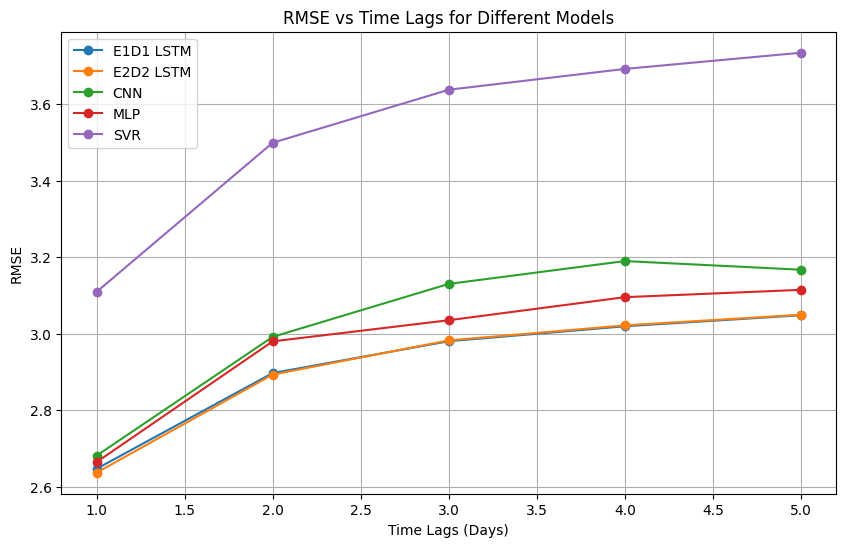

In [27]:
# Check shapes of y_test and predictions
print(f'y_test shape: {y_test.shape}')
print(f'pred_e1d1 shape: {pred_e1d1.shape}')
print(f'pred_e2d2 shape: {pred_e2d2.shape}')
print(f'pred_cnn shape: {pred_cnn.shape}')
print(f'pred_mlp shape: {pred_mlp.shape}')
print(f'pred_svr shape: {pred_svr.shape}')

# Initialize lists to store RMSE values for each model
rmse_e1d1 = []
rmse_e2d2 = []
rmse_cnn = []
rmse_mlp = []
rmse_svr = []

# Ensure predictions and y_test have the same length for each time lag
min_samples = min(y_test.shape[0], pred_e1d1.shape[0], pred_e2d2.shape[0],
                  pred_cnn.shape[0], pred_mlp.shape[0], pred_svr.shape[0])

# Calculate RMSE for each time lag
for j in range(1, 6):
    rmse_e1d1.append(sqrt(mean_squared_error(
        y_test[:min_samples, j-1], pred_e1d1[:min_samples, j-1])))
    rmse_e2d2.append(sqrt(mean_squared_error(
        y_test[:min_samples, j-1], pred_e2d2[:min_samples, j-1])))
    rmse_cnn.append(sqrt(mean_squared_error(
        y_test[:min_samples, j-1], pred_cnn[:min_samples, j-1])))
    rmse_mlp.append(sqrt(mean_squared_error(
        y_test[:min_samples, j-1], pred_mlp[:min_samples, j-1])))
    rmse_svr.append(sqrt(mean_squared_error(
        y_test[:min_samples, j-1], pred_svr[:min_samples, j-1])))

# Define time lags
time_lags = np.arange(1, 6)

# Plot RMSE vs Time Lags
plt.figure(figsize=(10, 6))

plt.plot(time_lags, rmse_e1d1, marker='o', label='E1D1 LSTM')
plt.plot(time_lags, rmse_e2d2, marker='o', label='E2D2 LSTM')
plt.plot(time_lags, rmse_cnn, marker='o', label='CNN')
plt.plot(time_lags, rmse_mlp, marker='o', label='MLP')
plt.plot(time_lags, rmse_svr, marker='o', label='SVR')

plt.xlabel('Time Lags (Days)')
plt.ylabel('RMSE')
plt.title('RMSE vs Time Lags for Different Models')
plt.legend()
plt.grid(True)
plt.show()

### RMSE vs Time lags comparison with early stoping

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


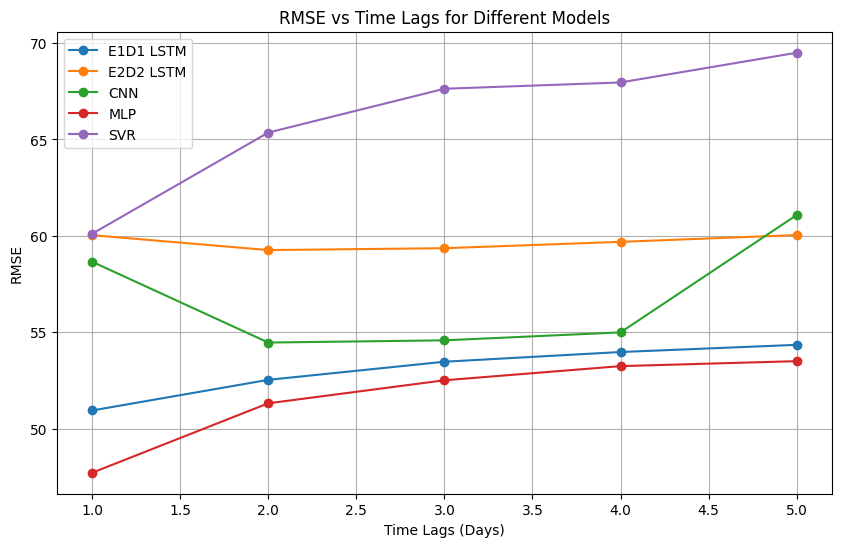

In [28]:
# Create and train MLP Regressor
mlp = MLPRegressor(hidden_layer_sizes=(
    100,),early_stopping=True, activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train_flat, y_train_flat)

# Predict with MLP
pred_mlp = mlp.predict(X_test_flat)
pred_mlp = pred_mlp.reshape(y_test.shape)

# Create and train SVR Regressor
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
pred_svr = np.zeros_like(y_test_flat)  # Initialize predictions

# Train and predict for each feature separately
for i in range(y_train_flat.shape[1]):
    svr.fit(X_train_flat, y_train_flat[:, i])
    pred_svr[:, i] = svr.predict(X_test_flat)

pred_svr = pred_svr.reshape(y_test.shape)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

# Train LSTM E1D1 with early stopping
history_e1d1 = model_e1d1.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),
                              batch_size=32, verbose=0, callbacks=[early_stop])

# Train LSTM E2D2 with early stopping
history_e2d2 = model_e2d2.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),
                              batch_size=32, verbose=0, callbacks=[early_stop])

# Train CNN with early stopping
history_cnn = model_cnn.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),
                            batch_size=32, verbose=0, callbacks=[early_stop])

# Predict with LSTM E1D1
pred_e1d1 = model_e1d1.predict(X_test)
# Predict with LSTM E2D2
pred_e2d2 = model_e2d2.predict(X_test)
# Predict with CNN
pred_cnn = model_cnn.predict(X_test)

# Inverse transform the predictions and y_test
for index, i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_e1d1[:, :, index] = scaler.inverse_transform(pred_e1d1[:, :, index])
    pred_e2d2[:, :, index] = scaler.inverse_transform(pred_e2d2[:, :, index])
    pred_cnn[:, :, index] = scaler.inverse_transform(pred_cnn[:, :, index])
    pred_mlp[:, :, index] = scaler.inverse_transform(pred_mlp[:, :, index])
    pred_svr[:, :, index] = scaler.inverse_transform(pred_svr[:, :, index])
    y_test[:, :, index] = scaler.inverse_transform(y_test[:, :, index])

# Initialize lists to store RMSE values for each model
rmse_e1d1 = []
rmse_e2d2 = []
rmse_cnn = []
rmse_mlp = []
rmse_svr = []

# Ensure predictions and y_test have the same length for each time lag
min_samples = min(y_test.shape[0], pred_e1d1.shape[0], pred_e2d2.shape[0],
                  pred_cnn.shape[0], pred_mlp.shape[0], pred_svr.shape[0])

# Calculate RMSE for each time lag
for j in range(1, 6):
    rmse_e1d1.append(sqrt(mean_squared_error(
        y_test[:min_samples, j-1], pred_e1d1[:min_samples, j-1])))
    rmse_e2d2.append(sqrt(mean_squared_error(
        y_test[:min_samples, j-1], pred_e2d2[:min_samples, j-1])))
    rmse_cnn.append(sqrt(mean_squared_error(
        y_test[:min_samples, j-1], pred_cnn[:min_samples, j-1])))
    rmse_mlp.append(sqrt(mean_squared_error(
        y_test[:min_samples, j-1], pred_mlp[:min_samples, j-1])))
    rmse_svr.append(sqrt(mean_squared_error(
        y_test[:min_samples, j-1], pred_svr[:min_samples, j-1])))

# Define time lags
time_lags = np.arange(1, 6)

# Plot RMSE vs Time Lags
plt.figure(figsize=(10, 6))

plt.plot(time_lags, rmse_e1d1, marker='o', label='E1D1 LSTM')
plt.plot(time_lags, rmse_e2d2, marker='o', label='E2D2 LSTM')
plt.plot(time_lags, rmse_cnn, marker='o', label='CNN')
plt.plot(time_lags, rmse_mlp, marker='o', label='MLP')
plt.plot(time_lags, rmse_svr, marker='o', label='SVR')

plt.xlabel('Time Lags (Days)')
plt.ylabel('RMSE')
plt.title('RMSE vs Time Lags for Different Models')
plt.legend()
plt.grid(True)
plt.show()